In [1]:
%matplotlib inline
import seaborn
import talib
import matplotlib as mpl
import pandas as pd
import numpy as np
import os,sys            # 枚举文件工具包
import multiprocessing as mp
import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.svm import SVC  # SVM下的分类问题；还有SVR；
from sklearn.metrics import accuracy_score          # 打分工具包
from sklearn.linear_model import LogisticRegression    # 逻辑回归分类
from sklearn.tree import DecisionTreeClassifier        # 决策树分类
from sklearn.ensemble import RandomForestClassifier     # 随机森林分类
from sklearn.neighbors import KNeighborsClassifier    # knn分类
from sklearn.naive_bayes import GaussianNB          # 朴素贝叶斯分类
from sklearn.neural_network import MLPClassifier   # 神经网络分类
from sklearn.ensemble import BaggingClassifier    # 装袋集成分类
from sklearn.ensemble import AdaBoostClassifier    # 迭代分类算法
from sklearn.ensemble import GradientBoostingClassifier    # Gradient Tree Boosting算法

In [2]:
class all_sklearn_modal():   #把数据加工成最终策略和收益图
    def __init__(self, ratio, path_raw='', path_proced='', path_result='', path_modal='', 
                 path_result_combo='', path_plot='', path_critical='', max_num=3):
# path_raw:原始数据 path_proced:加工后的标签数据, path_result:训练后的结果数据,
# path_result_combo:比例结果组合, path_plot:收益图（以上表示数据存取路径）
# path_critical:结果评测表，ratio:所有比例(list) number:收益率前几个策略（int） 
        self.pa_raw = path_raw
        self.pa_proced = path_proced
        self.pa_result = path_result
        self.pa_result_combo = path_result_combo
        self.pa_plot = path_plot
        self.ratio = ratio
        self.max_num = max_num
        self.pa_mo = path_modal
        self.pa_cri = path_critical
        self.l_name = ['svc','log','dt','rf','knn','nb','net','bag_svc','bag_log',
                     'bag_dt','bag_rf','bag_knn','bag_nb','bag_net','ab','gb']
        self.arr = np.zeros((31*10,16*5))

    def proc_zhibiao(self):
    # 需参：pa_raw pa_proced
    # 作用：把从通达信下载的数据处理成含有5，10，20，60均线，kdj和macd指标
        dirs = os.listdir(self.pa_raw)
        for f in dirs:
            datas=pd.DataFrame()
            data=pd.read_excel(self.pa_raw+f)#sheetname='RSL8'
            data.rename(columns=data.iloc[1,:],inplace=True)   
            data.drop([1],axis=0,inplace=True)
            data.dropna(how='any',axis=0,inplace=True)
            datas['time']=data.iloc[:,0]            # 数据处理，提取其中时间。开盘价。最高价。最低价。收盘价
            datas['open']=data.iloc[:,1]            # 成交量。持仓量 
            datas['high']=data.iloc[:,2]
            datas['low']=data.iloc[:,3]
            datas['close']=data.iloc[:,4]
            datas['volums']=data.iloc[:,5]
            #datas['hold_vol']=data['  VOL.VOLUME']
            datas.set_index(datas['time'],inplace=True)
            datas.sort_index(inplace=True)
        

#                                    计算kdj指标
            n=9
            datas['low_list'] = datas['low'].rolling(n, min_periods=n).min()
            datas['low_list'].fillna(value = datas['low'].expanding().min(), inplace = True)
            high_list = datas['high'].rolling(n, min_periods=n).max()
            high_list.fillna(value = datas['high'].expanding().max(), inplace = True)
            datas['dif_hl']=high_list - datas['low_list']
            datas=datas[~datas['dif_hl'].isin([0])]
            rsv = (datas['close'] - datas['low_list']) / (datas['dif_hl']) * 100
            rsv = pd.DataFrame(rsv)
            del datas['low_list']             
            del datas['dif_hl']
            datas['k']=50
            datas['d']=50
            datas['j']=0
            datas['rsv']=rsv

            leng=len(datas)
            k=6
            for i in range(n-1,leng):
                #datas.iloc[i,k]=2/3*datas.iloc[i-1,k]+1/3*datas.iloc[i,k+3]
                datas.iloc[i,k]=2/3*datas.iloc[i-1,k]+1/3*datas.iloc[i,k+3]
                datas.iloc[i,k+1]=2/3*datas.iloc[i-1,k+1]+1/3*datas.iloc[i,k]
                datas.iloc[i,k+2]=3*datas.iloc[i,k]-2*datas.iloc[i,k+1]
            datas.iloc[:n-1,k+2]=50
            del datas['rsv']
        
#                          计算['5','10','20','60']均线
            a=['5','10','20','60']
            for i in a: 
                kk=int(i)
                datas['MA'+i] = talib.MA(datas['close'], timeperiod=kk) 

#                           计算MACD指标
            datas['DIF'],datas['DEA'],datas['MACD'] = talib.MACD(datas['close'],fastperiod=12, slowperiod=26, signalperiod=9)   
            datas['MACD']=datas['MACD']*2    
            
#                              计算CCI指标  
#             CCI（N日）=（TP－MA）÷MD÷0.015      N=10
#             其中，TP=（最高价+最低价+收盘价）÷3
#             MA=近N日收盘价的累计之和÷N
#             MD=近N日（MA－收盘价）的累计之和÷N
#             0.015为计算系数，N为计算周期

#             datas['TP'] = (datas['high']+datas['low']+datas['close'])/3
#             datas['MD'] = (datas['MA10']-datas['close']).rolling(10).mean()
#             datas['CCI'] = (datas['TP']-datas['MA10'])/datas['MD']/0.015
#             datas.drop(['TP', 'MD'], axis=1, inplace=True)
            
#                               计算ATR真实波幅
#             TR=∣最高价-最低价∣和∣最高价-昨收∣和∣昨收-最低价∣的最大值
#             =max(max(∣H-L∣,∣H-PC∣),∣PC-L∣)            
#             2.真实波幅（ATR）=TR的N日简单移动平均
#             3.参数N设置为14日 [2] 

#             datas['TR'] = np.nan             #datas.close.shift(1)[i]
#             for tr in range(1,len(datas)):
#                 datas.TR[i] = max(abs(datas.high[i]-datas.low[i]),abs(datas.high[i]-datas.close[i-1]),
#                                   abs(datas.close[i-1]-datas.low[i]))
#             datas.dropna(how='any',axis=0,inplace=True)
#             datas['ATR'] = talib.MA(datas['TR'], timeperiod=14) 
#             datas.dropna(how='any',axis=0,inplace=True)
#             del datas['TR']
            
            del datas['time']
            writer=pd.ExcelWriter(self.pa_proced+f) 
            datas.to_excel(writer,'Sheet1')
            #data.to_excel(writer,'Sheet1')
            writer.save()
    
    
#     def proc_zhibiao_pool(self):
        
#         pool = mp.Pool(processes = 2)
#         pool.map(self.proc_zhibiao,self.dirs)

        
    def sklearn_ratio(self):
        # 需参：pa_proced,pa_result,ratio
        # 作用：对每个期货品种每个模型每个比例进行训练和预测
        init_count = 20000               # 初始资金
        k = 0         # 统计步数
        dirs = os.listdir(self.pa_proced)
        path = self.pa_proced
        pp=self.ratio
        modal_name = self.l_name
        path_mo=self.pa_mo
        arr = self.arr
        
     # criti表里包含模型准确率，总收益，平均收益，平均有效收益，0所占比例，总条数，亏损条数
        criti = pd.DataFrame()
#         arr = np.zeros((len(dirs)*8,16*5))
        index = list()        # criti索引
        
        for f in dirs:
            
            ff = f[:-5]
            
            if (ff == 'AL') | (ff == 'L') | (ff == 'RU') | (ff == 'ZN'):
                charge = 5
            elif ff == 'AU':                                     # 计算最小变动价位
                charge = 0.05
            elif (ff == 'BU') | (ff == 'P') | (ff == 'SM') | (ff == 'TA') | (ff == 'Y'):
                charge = 2
            elif (ff == 'CU') | (ff == 'NI'):
                charge=10
            elif (ff == 'I') | (ff == 'J') | (ff == 'JM'):
                charge=0.5
            elif ff == 'ZC':
                charge=0.2
            else:
                charge=1
                
            if (ff == 'C')|(ff == 'CS')|(ff == 'JD')|(ff == 'PP')|(ff == 'SM')|(ff == 'WH'):
                day = 4
            elif (ff == 'OI')|(ff == 'RM')|(ff == 'SR')|(ff == 'TA')|(ff == 'ZC'):
                day = 7                                
            elif (ff == 'FU'):                               # 计算每天小时数
                day = 5
            elif (ff == 'AL')|(ff == 'CU')|(ff == 'NI')|(ff == 'ZN'):
                day == 8
            elif (ff == 'AC')|(ff == 'AU')|(ff == 'SC'):
                day = 10
            else:
                day = 6
            
            if ff == 'NI':
                ton = 1
            elif (ff == 'AL')|(ff == 'CU')|(ff == 'L')|(ff == 'PP')|(ff == 'SM')|(ff == 'TA')|(ff == 'ZN'):
                ton = 5
            elif (ff == 'AU')|(ff == 'SC'):
                ton = 1000
            elif (ff == 'AG'):
                ton = 16
            elif (ff == 'WH'):
                ton = 20
            elif (ff == 'JM'):
                ton = 60
            elif (ff == 'I')|(ff == 'J')|(ff == 'ZC'):
                ton = 100
            else:
                ton = 10
            
            ss=f[:-5]+'_'
            index = index + [ss+'acc',ss+'pct_0',ss+'returns',ss+'ava',ss+'eff_ava',
                             ss+'win_rate',ss+'win_totalrate',ss+'MW_rate',ss+'SR',ss+'total']
            c1 = 0
            R = np.sqrt(252*day)
            for pc in pp:
                
                datas_pd = pd.read_excel(path+f)
                datas_pd.dropna(axis=0, how='any',inplace=True)
                time = datas_pd['time'].copy()
                del datas_pd['time']            # 删除行
                del datas_pd['time.1']
                datas_pd.set_index(time,inplace=True)
                res=pd.DataFrame()
                da=pd.DataFrame()                       # 创建表格

#                 datas_pd = datas_pd.iloc[-3500:,:]
                res['time']=time                                               #   res[0]
                res.set_index(res['time'],inplace=True)
                

#                 datas_pd['pct']=datas_pd['close']-datas_pd['open']  #.pct_change()    # 计算收益率
                datas_pd['pct']=datas_pd['close']/datas_pd['open']-1  #.pct_change()    # 计算收益率
                res['dif']=datas_pd['close']-datas_pd['open']                             #    res[1]
                da['pric']=(datas_pd['close'].values+datas_pd['open'].values)*0.0001+charge
                
                
                    
                da.set_index(res['time'],inplace=True)

#                 da['sig']=np.where(datas_pd['pct']>da['pric'],1,0)      # 判断信号                   da[0]   
#                 da['sig']=np.where(datas_pd['pct']<-da['pric'],2,da['sig'])
                da['sig']=np.where(datas_pd['pct']>pc,1,0)      # 判断信号                   da[0]   
                da['sig']=np.where(datas_pd['pct']<-pc,2,da['sig'])
                del datas_pd['pct']

                datas_pd=datas_pd.apply(lambda x: (x - np.mean(x)) / np.std(x))  # 标准化
                datas_pd['sig']=da['sig'].shift(-1).values        # 把信号放入总表格里
                datas_pd.dropna(how='any',axis=0,inplace=True)       # 去除含有nan值的行

                le=datas_pd.shape[0]          # 获取行数量
                le=int(le*0.7)                    # 截取70%作为训练集
                datas_train=datas_pd.iloc[:le]
                datas_test=datas_pd.iloc[le:]
                res=res[le:]            # 截取30%
                res.drop(res.index[len(res.index)-1], axis=0,inplace=True)  # 删除res最后一行
                da=da[le:]
                da.drop(da.index[len(da.index)-1], axis=0,inplace=True)  # 删除res最后一行
                da.set_index(res['time'],inplace=True)

                y_train=datas_train['sig'].values   # dataframe转换成array
                del datas_train['sig']                    # 删除信号列
                x_train=datas_train.values 

                y_test=datas_test['sig'].values   # dataframe转换成array
                del datas_test['sig']                    # 删除信号列
                x_test=datas_test.values 

                clf_SVC = SVC()                # svm算法               #默认的核函数就是rbf；
                clf_SVC.fit(x_train,y_train)       # 训练；
                pred_SVC = clf_SVC.predict(x_test)     # 返回是测试集的预测的label；
                arr[k,0+c1] = accuracy_score(pred_SVC, y_test)        # 计算准确率   
                counts = pd.Series(pred_SVC).value_counts()
                if 0 in counts:
                    arr[k+1,0+c1] = counts[0]/len(pred_SVC)  # 0所占比例
                else:
                    arr[k+1,0+c1] = 0  # 0所占比例
                res['svc'] = pred_SVC                                                          #   res[2]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_svc_zhibiao.pkl'
                joblib.dump(clf_SVC, pa) 
                #clf = joblib.load('filename.pkl') 


                clf_LR = LogisticRegression()     #定义了逻辑回归的分类器，clf_LR，初始化模型；
                clf_LR.fit(x_train,y_train)         # 逻辑回归算法
                pred_LR = clf_LR.predict(x_test)
                arr[k,1+c1] = accuracy_score(pred_LR, y_test)
                counts = pd.Series(pred_LR).value_counts()
                if 0 in counts:
                    arr[k+1,1+c1] = counts[0]/len(pred_LR)  # 0所占比例
                else:
                    arr[k+1,1+c1] = 0  # 0所占比例
                res['log'] = pred_LR                                                            #  res[3]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_lr_zhibiao.pkl'
                joblib.dump(clf_LR, pa) 

                clf_DT = DecisionTreeClassifier()
                clf_DT.fit(x_train,y_train)              # 决策树算法
                pred_DT = clf_DT.predict(x_test)
                arr[k,2+c1] = accuracy_score(pred_DT, y_test)
                counts = pd.Series(pred_DT).value_counts()
                if 0 in counts:
                    arr[k+1,2+c1] = counts[0]/len(pred_DT)  # 0所占比例
                else:
                    arr[k+1,2+c1] = 0  # 0所占比例
                res['dt']=pred_DT                                                            #   res[4]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_dt_zhibiao.pkl'
                joblib.dump(clf_DT, pa) 

                clf_RF = RandomForestClassifier()
                clf_RF.fit(x_train,y_train)             # 随机森林算法
                pred_RF = clf_RF.predict(x_test)
                arr[k,3+c1] = accuracy_score(pred_RF, y_test)
                counts = pd.Series(pred_RF).value_counts()
                if 0 in counts:
                    arr[k+1,3+c1] = counts[0]/len(pred_RF)  # 0所占比例
                else:
                    arr[k+1,3+c1] = 0  # 0所占比例
                res['rf']=pred_RF                                                            #   res[5]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_rf_zhibiao.pkl'
                joblib.dump(clf_RF, pa) 

                clf_KNN = KNeighborsClassifier(n_neighbors=7)
                clf_KNN.fit(x_train,y_train)                # knn算法
                pred_KNN = clf_KNN.predict(x_test)
                arr[k,4+c1] = accuracy_score(pred_KNN, y_test)
                counts = pd.Series(pred_KNN).value_counts()
                if 0 in counts:
                    arr[k+1,4+c1] = counts[0]/len(pred_KNN)  # 0所占比例
                else:
                    arr[k+1,4+c1] = 0  # 0所占比例
                res['knn']=pred_KNN                                                         #   res[6]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_knn_zhibiao.pkl'
                joblib.dump(clf_KNN, pa) 

                clf_NB = GaussianNB()    # 朴素贝叶斯算法
                clf_NB.fit(x_train,y_train)    
                pred_NB = clf_NB.predict(x_test)  
                arr[k,5+c1] = accuracy_score(pred_NB, y_test)
                counts = pd.Series(pred_NB).value_counts()
                if 0 in counts:
                    arr[k+1,5+c1] = counts[0]/len(pred_NB)  # 0所占比例
                else:
                    arr[k+1,5+c1] = 0  # 0所占比例
                res['nb']=pred_NB                                                           #   res[7]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_nb_zhibiao.pkl'
                joblib.dump(clf_NB, pa) 

                indim=datas_train.shape[1]+6
                clf_NET = MLPClassifier(solver='lbfgs', alpha=1e-5,
                                        hidden_layer_sizes=(indim, indim), random_state=1)
                clf_NET.fit(x_train,y_train)              # 神经网络算法
                pred_NET = clf_NET.predict(x_test)
                arr[k,6+c1] = accuracy_score(pred_NET, y_test)
                counts = pd.Series(pred_NET).value_counts()
                if 0 in counts:
                    arr[k+1,6+c1] = counts[0]/len(pred_NET)  # 0所占比例
                else:
                    arr[k+1,6+c1] = 0  # 0所占比例
                res['net']=pred_NET                                                         #   res[8]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_network_zhibiao.pkl'
                joblib.dump(clf_NET, pa) 

                # 下面都是集成算法
                clf_BAG_SVC = BaggingClassifier(SVC(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_SVC.fit(x_train,y_train)              # 装袋算法（SVC）
                pred_BAG_SVC = clf_BAG_SVC.predict(x_test)
                arr[k,7+c1] = accuracy_score(pred_BAG_SVC, y_test)
                counts = pd.Series(pred_BAG_SVC).value_counts()
                if 0 in counts:
                    arr[k+1,7+c1] = counts[0]/len(pred_BAG_SVC)  # 0所占比例
                else:
                    arr[k+1,7+c1] = 0  # 0所占比例
                res['bag_svc']=pred_BAG_SVC                                                 #   res[9]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_SVC_zhibiao.pkl'
                joblib.dump(clf_BAG_SVC, pa) 

                clf_BAG_LOG = BaggingClassifier(LogisticRegression(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_LOG.fit(x_train,y_train)              # 装袋算法（LOG）
                pred_BAG_LOG = clf_BAG_LOG.predict(x_test)
                arr[k,8+c1] = accuracy_score(pred_BAG_LOG, y_test)
                counts = pd.Series(pred_BAG_LOG).value_counts()
                if 0 in counts:
                    arr[k+1,8+c1] = counts[0]/len(pred_BAG_LOG)  # 0所占比例
                else:
                    arr[k+1,8+c1] = 0  # 0所占比例
                res['bag_log']=pred_BAG_LOG                                                 #   res[10]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_log_zhibiao.pkl'
                joblib.dump(clf_BAG_LOG, pa) 

                clf_BAG_DT = BaggingClassifier(DecisionTreeClassifier(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_DT.fit(x_train,y_train)              # 装袋算法（DT）
                pred_BAG_DT = clf_BAG_DT.predict(x_test)
                arr[k,9+c1] = accuracy_score(pred_BAG_DT, y_test)
                counts = pd.Series(pred_BAG_DT).value_counts()
                if 0 in counts:
                    arr[k+1,9+c1] = counts[0]/len(pred_BAG_DT)  # 0所占比例
                else:
                    arr[k+1,9+c1] = 0  # 0所占比例
                res['bag_dt']=pred_BAG_DT                                                   #   res[11]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_dt_zhibiao.pkl'
                joblib.dump(clf_BAG_DT, pa) 

                clf_BAG_RF = BaggingClassifier(RandomForestClassifier(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_RF.fit(x_train,y_train)              # 装袋算法（RF）
                pred_BAG_RF = clf_BAG_RF.predict(x_test)
                arr[k,10+c1] = accuracy_score(pred_BAG_RF, y_test)
                counts = pd.Series(pred_BAG_RF).value_counts()
                if 0 in counts:
                    arr[k+1,10+c1] = counts[0]/len(pred_BAG_RF)  # 0所占比例
                else:
                    arr[k+1,10+c1] = 0  # 0所占比例
                res['bag_rf']=pred_BAG_RF                                                   #   res[12]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_rf_zhibiao.pkl'
                joblib.dump(clf_BAG_RF, pa) 


                clf_BAG_KNN = BaggingClassifier(KNeighborsClassifier(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_KNN.fit(x_train,y_train)              # 装袋算法（knn）
                pred_BAG_KNN = clf_BAG_KNN.predict(x_test)
                arr[k,11+c1] = accuracy_score(pred_BAG_KNN, y_test)
                counts = pd.Series(pred_BAG_KNN).value_counts()
                if 0 in counts:
                    arr[k+1,11+c1] = counts[0]/len(pred_BAG_KNN)  # 0所占比例
                else:
                    arr[k+1,11+c1] = 0  # 0所占比例
                res['bag_knn']=pred_BAG_KNN                                                 #   res[13]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_knn_zhibiao.pkl'
                joblib.dump(clf_BAG_KNN, pa) 

                clf_BAG_NB = BaggingClassifier(GaussianNB(),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_NB.fit(x_train,y_train)              # 装袋算法（NB）
                pred_BAG_NB = clf_BAG_NB.predict(x_test)
                arr[k,12+c1] = accuracy_score(pred_BAG_NB, y_test)
                counts = pd.Series(pred_BAG_NB).value_counts()
                if 0 in counts:
                    arr[k+1,12+c1] = counts[0]/len(pred_BAG_NB)  # 0所占比例
                else:
                    arr[k+1,12+c1] = 0  # 0所占比例
                res['bag_nb']=pred_BAG_NB                                                   #   res[14]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_nb_zhibiao.pkl'
                joblib.dump(clf_BAG_NB, pa) 

                clf_BAG_NET = BaggingClassifier(MLPClassifier(solver='lbfgs', alpha=1e-5,
                                                             hidden_layer_sizes=(indim, indim), random_state=1),
                                            max_samples=0.5, max_features=0.5)
                clf_BAG_NET.fit(x_train,y_train)              # 装袋算法（NET）
                pred_BAG_NET = clf_BAG_NET.predict(x_test)
                arr[k,13+c1] = accuracy_score(pred_BAG_NET, y_test)
                counts = pd.Series(pred_BAG_NET).value_counts()
                if 0 in counts:
                    arr[k+1,13+c1] = counts[0]/len(pred_BAG_NET)  # 0所占比例
                else:
                    arr[k+1,13+c1] = 0  # 0所占比例
                res['bag_net']=pred_BAG_NET                                                 #   res[15]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_bagging_net_zhibiao.pkl'
                joblib.dump(clf_BAG_NET, pa) 

                clf_AB = AdaBoostClassifier()
                clf_AB.fit(x_train,y_train)              # AB迭代分类算法
                pred_AB = clf_AB.predict(x_test)
                arr[k,14+c1] = accuracy_score(pred_AB, y_test)
                counts = pd.Series(pred_AB).value_counts()
                if 0 in counts:
                    arr[k+1,14+c1] = counts[0]/len(pred_AB)  # 0所占比例
                else:
                    arr[k+1,14+c1] = 0  # 0所占比例
                res['ab']=pred_AB                                                           #   res[16]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_ab_zhibiao.pkl'
                joblib.dump(clf_AB, pa)     

                clf_GB = GradientBoostingClassifier() 
                clf_GB.fit(x_train,y_train)              # GBDT算法
                pred_GB = clf_GB.predict(x_test)
                arr[k,15+c1] = accuracy_score(pred_GB, y_test)
                counts = pd.Series(pred_GB).value_counts()
                if 0 in counts:
                    arr[k+1,15+c1] = counts[0]/len(pred_GB)  # 0所占比例
                else:
                    arr[k+1,15+c1] = 0  # 0所占比例
                res['gb']=pred_GB                                                           #   res[17]
                pa=path_mo+str(pc)+'_'+f[:-5]+'_GB_zhibiao.pkl'
                joblib.dump(clf_GB, pa)
                
                res['y_test']=y_test                                                        #   res[18]
                col=res.shape[1]
                for i in range(len(res)):
                    for j in range(2,col):           # 把信号2变为-1
                        res.iloc[i,j]=np.where(res.iloc[i,j]==2,-1,res.iloc[i,j])

                l_name=self.l_name

                res['cum_ret']=0                                                           #   res[19]
                for j in range(1,len(res)):           # 计算市场累计收益
                    res.iloc[j,col] = res.iloc[j,1]+res.iloc[j-1,col] 


                bb=res.shape[1]+1
                c2 = 0
                for i in l_name:                   #   计算策略的累积收益
                    res['pred_'+i]=res[i].shift(1)*res['dif']-da['pric']*abs(res[i].values)
                    res['cum_'+i]=0
                    sig1 = np.sign(res['pred_'+i]).value_counts()
                    if 1 in sig1:
                        arr[k+5,c2+c1] = sig1[1]/len(res)         # 获取交易成功比例
                    else:
                        arr[k+5,c2+c1] = 0
                    for j in range(1,len(res)):             # 计算累计收益
                        res.iloc[j,bb] = res.iloc[j,bb-1]+res.iloc[j-1,bb]  
                        
                    arr[k+2,c2+c1] = res.iloc[-1,-1]*ton                  # 获取总收益
                    arr[k+3,c2+c1] = res.iloc[-1,-1]/len(res)*ton            # 获取每小时平均收益
                    arr[k+4,c2+c1] = arr[k+3,c2+c1]/(1-arr[k+1,c2+c1])*ton      # 获取有效平均收益（减去0部份）
                    sig2 = np.sign(res['cum_'+i]).value_counts()
                    if 1 in sig2:
                        arr[k+6,c2+c1] = sig2[1]/len(res)     # 获取累计收益为正的比例
                    else:
                        arr[k+6,c2+c1] = 0
                    arr[k+8,c2+c1] = (arr[k+3,c2+c1]*R/init_count-0.03/R)/np.std(res['pred_'+i]*ton/init_count)  # 计算夏普比率
                    del res['pred_'+i]
                    c2+=1
                    bb+=1
                    
                c3 = 0    
                for i in l_name:
                    co = res['cum_'+i]+init_count
                    MAX = co[0]
                    mw = list([0])                               # 计算最大回撤率
                    for j in range(len(res)):
                        MAX = max(MAX,co[j])
                        if MAX>co[j]:
                            mw.append((MAX-co[j])/MAX)
                    arr[k+7,c3+c1]=max(mw)
                    c3+=1
                    
                c1+=16
                del res['time']
#                 writer=pd.ExcelWriter(self.pa_result+str(pc)+'_'+f)    # 把res表格存放在excl文件中
                res.to_excel(self.pa_result+str(pc)+'_'+f)
#                 writer.save()
            
            arr[k+9,:] = len(res)
            k += 10
        
        c4 = 0
        for i in pp:                # 设置criti的columns
            for j in modal_name:
                criti[str(i)+'_'+j] = arr[:,c4]
                c4+=1
        index = np.array(index)
        criti.set_index(index,inplace=True)
        criti.to_excel(self.pa_cri+'critical8.xlsx')
        

#     def sklearn_ratio_pool(self):
        
#         pool = mp.Pool(processes = 2)
#         pool.map(self.sklearn_ratio,dirs)
    
    def learning_combo(self):
    # 需参：pa_rresult, pa_result_combo, ratio
        ra=self.ratio
        ratio=[str(ra[1]),str(ra[0]),str(ra[3]),str(ra[2]),str(ra[4])]
        contract=len(ratio)
        dirs = os.listdir(self.pa_result)       # 获取文件夹的所有文件名
        cu=int(len(dirs)/contract)           # 计算合约种类数
        for f in range(cu):
            aa=0
            data1=pd.read_excel(self.pa_result+dirs[f+aa])
            aa+=cu
            data2=pd.read_excel(self.pa_result+dirs[f+aa])
            #data2.drop(data2.columns['dif', 'cum_ret'], axis=1, inplace=True)
            data2.drop(['dif', 'cum_ret'], axis=1, inplace=True)
            aa+=cu
            data3=pd.read_excel(self.pa_result+dirs[f+aa])
            data3.drop(['dif', 'cum_ret'], axis=1, inplace=True)
            aa+=cu
            data4=pd.read_excel(self.pa_result+dirs[f+aa])
            data4.drop(['dif', 'cum_ret'], axis=1, inplace=True)
            aa+=cu
            data5=pd.read_excel(self.pa_result+dirs[f+aa])
            data5.drop(['dif', 'cum_ret'], axis=1, inplace=True)
            
            
            a1=data1['y_test'].value_counts()
            data1.rename(columns={'y_test':str(a1)[:-14]+'_'+ratio[0]},inplace=True)
            a2=data2['y_test'].value_counts()
            data2.rename(columns={'y_test':str(a2)[:-14]+'_'+ratio[1]},inplace=True)
            a3=data3['y_test'].value_counts()
            data3.rename(columns={'y_test':str(a3)[:-14]+'_'+ratio[2]},inplace=True)
            a4=data4['y_test'].value_counts()
            data4.rename(columns={'y_test':str(a4)[:-14]+'_'+ratio[3]},inplace=True)
            a5=data5['y_test'].value_counts()
            data1.rename(columns={'y_test':str(a5)[:-14]+'_'+ratio[4]},inplace=True)

            l_name=self.l_name

            for i in l_name:
                a1=data1[i].value_counts()
                data1.rename(columns={i:str(a1)[:-14]+'_'+ratio[0]},inplace=True)
                a2=data2[i].value_counts()
                data2.rename(columns={i:str(a2)[:-14]+'_'+ratio[1]},inplace=True)
                a3=data3[i].value_counts()
                data3.rename(columns={i:str(a3)[:-14]+'_'+ratio[2]},inplace=True)
                a4=data4[i].value_counts()
                data4.rename(columns={i:str(a4)[:-14]+'_'+ratio[3]},inplace=True)
                a5=data5[i].value_counts()
                data1.rename(columns={i:str(a5)[:-14]+'_'+ratio[4]},inplace=True)

            res1=pd.merge(data1, data2, on = 'time',suffixes=['','_'+ratio[1]])
            res2=pd.merge(data3, data4, on = 'time',suffixes=['_'+ratio[2],'_'+ratio[3]])
            res3=pd.merge(res1, res2, on = 'time')
            res4=pd.merge(res3, data5, on = 'time',suffixes=['_'+ratio[0],'_'+ratio[4]])

            #col=res.shape[1]
            #for 
            writer=pd.ExcelWriter(self.pa_result_combo+dirs[f][len(ratio[0]):]) 
            res4.to_excel(writer,'Sheet1')
            #data.to_excel(writer,'Sheet1')
            writer.save()
    
    
    def plot_max(self):
    # 需参：pa_result_combo, pa_plot, max_num
    # 作用：画出并保存每个期货前max_num个收益的图
#         pa=self.pa_result_combo
        pa=self.pa_result_combo
        dirs = os.listdir(pa)
        for f in dirs:
            res=pd.DataFrame()
            data=pd.read_excel(pa+f)
            del data['Unnamed: 0']
            data.set_index(data['time'],inplace=True)
            del data['time']
            res['cum_ret']=data['cum_ret'].copy()
            del data['cum_ret']

            for jj in range(self.max_num):
                if data.iloc[-1].max()>1:
                    max1 = data.iloc[-1].argmax()
                    res[max1]=data[max1].copy()
                    del data[max1]
                else:
                    break

            ax = res.plot(title=f[:-5],figsize=(18, 12))
            fig = ax.get_figure()
            fig.savefig(self.pa_plot+f[:-4]+'png') 
            #print(self.pa_plot+f[:-4]+'png')
    
    
    def modal_use(self,pa_datas,pa_modal,pa_result):
        # 数据路径，机器模型
        # 作用：导入模型计算收益
        dirs_datas = os.listdir(pa_datas)
        dirs_modal = os.listdir(pa_modal)
        le_datas = len(dirs_datas)
        le_modal = int(len(dirs_modal)/le_datas)
        for f in dirs_datas:
            datas = pd.read_excel(pa_datas+f)
            res=pd.DataFrame()
            datas.set_index(datas['time'],inplace=True)
            del datas['time']
            datas.dropna(axis=0, how='any',inplace=True)
            res['dif']=datas['close']-datas['open']
            datas=datas.apply(lambda x: (x - np.mean(x)) / np.std(x))  # 标准化
            x=datas.values
            for k in le_modal:
                mo = dirs_modal[k+le_datas*k]
                clf = joblib.load(pa_modal+mo)
                res[mo[:-12]]=clf.predict(x)
        
            col=res.shape[1]
            for i in range(len(res)):
                for j in range(1,col):           # 把信号2变为-1
                    res.iloc[i,j]=np.where(res.iloc[i,j]==2,-1,res.iloc[i,j])

            bb=res.shape[1]+1
            for i in dirs:                   #   计算策略的累积收益
                i=i[:-12]
                res['pred_'+i]=res[i].shift(1)*res['dif']-0.1*abs(res[i].values)
                res['cum_'+i]=0
                for j in range(1,len(res)):
                    res.iloc[j,bb] = res.iloc[j,bb-1]+res.iloc[j-1,bb]
                del res['pred_'+i]
                bb+=1

            # del res['time']
            writer=pd.ExcelWriter(pa_result+mo[:-12]+'.xlsx')    # 把res表格存放在excl文件中
            res.to_excel(writer,'Sheet1')
            writer.save()
        
    
    def main_fit(self):
#         self.proc_zhibiao()
        self.sklearn_ratio()
        self.learning_combo()
        self.plot_max()
        
    def fit(self):
#         self.sklearn_ratio()
        self.learning_combo()
        self.plot_max()

In [3]:
path_proced="C:\\Users\\mlWin\\量化\\data_proce\\proced_hour_zhibiao\\hour\\"
path_result="C:\\Users\\mlWin\\量化\\data_proce\\cla_hour_pro_zhibiao\\da_oc_8\\"
path_result_combo="C:\\Users\\mlWin\\量化\\data_proce\\learning_combo\\values_combo8\\"
path_plot="C:\\Users\\mlWin\\量化\\data_proce\\plot\\plot_max_8\\"
path_modal="C:\\Users\\mlWin\\量化\\data_proce\\cla_hour_pro_zhibiao\\modal\\"
path_raw="C:\\Users\\mlWin\\量化\\data_proce\\raw_datas\\datas_min\\"
path_critical='C:\\Users\\mlWin\\量化\\data_proce\\critical\\'
ratio=[0.001, 0.0015, 0.002, 0.0025, 0.003]
ma=all_sklearn_modal(ratio=ratio,path_raw=path_raw, path_proced= path_proced, path_result=path_result, 
                     path_modal=path_modal, path_result_combo=path_result_combo, path_plot=path_plot, 
                     path_critical=path_critical, max_num=3)


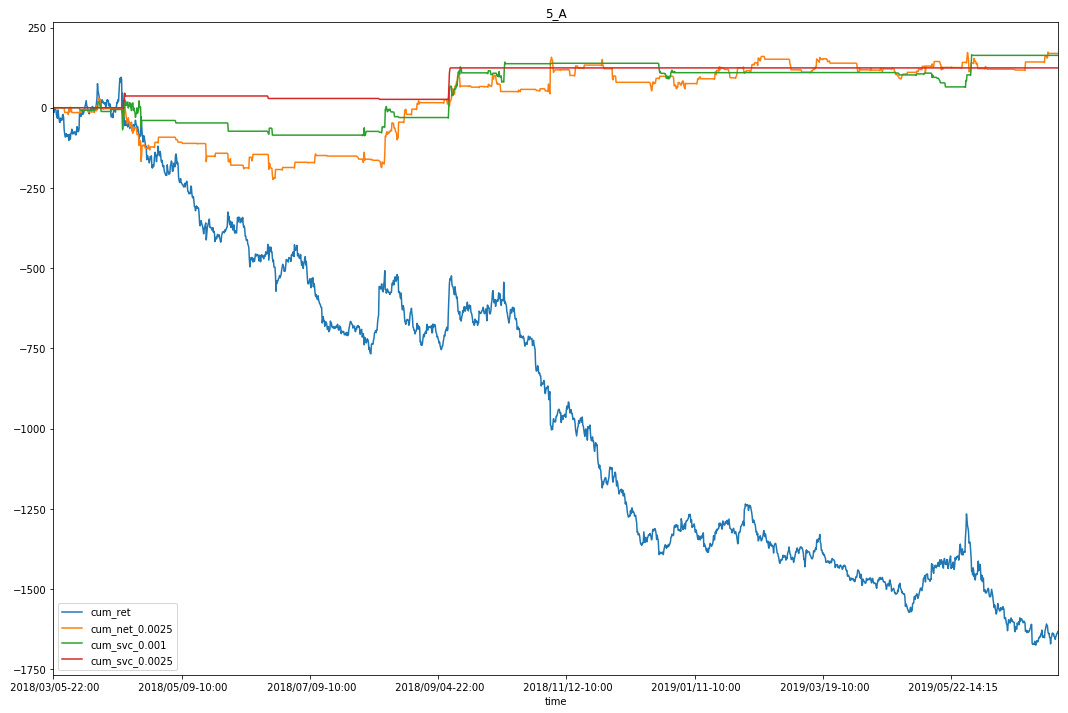

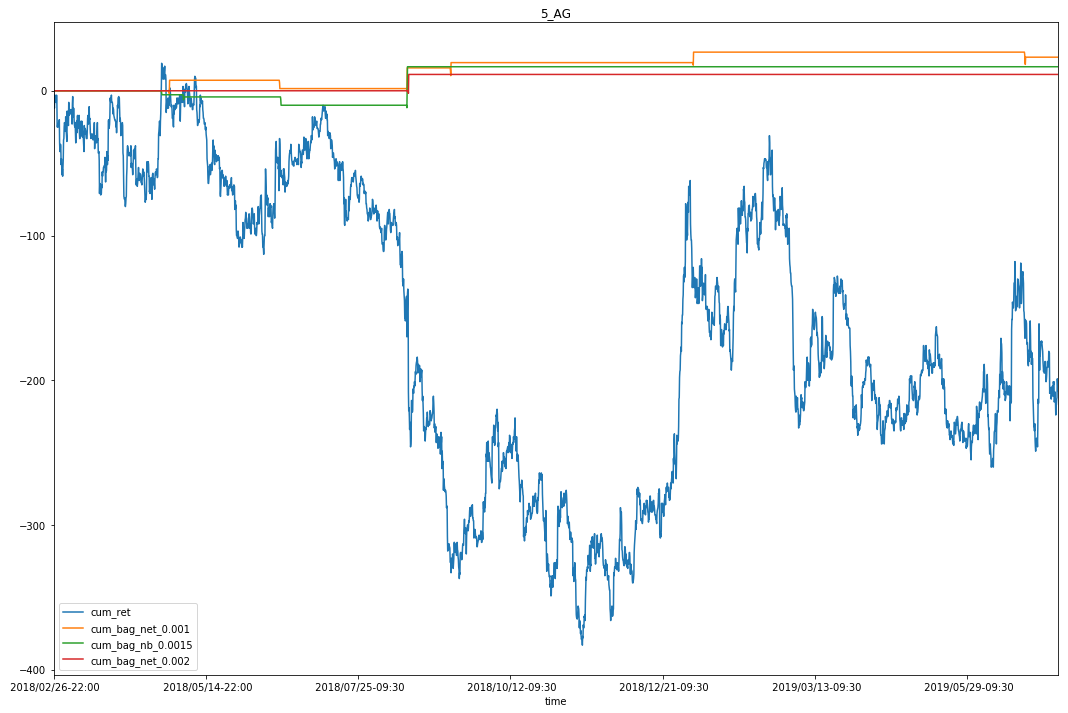

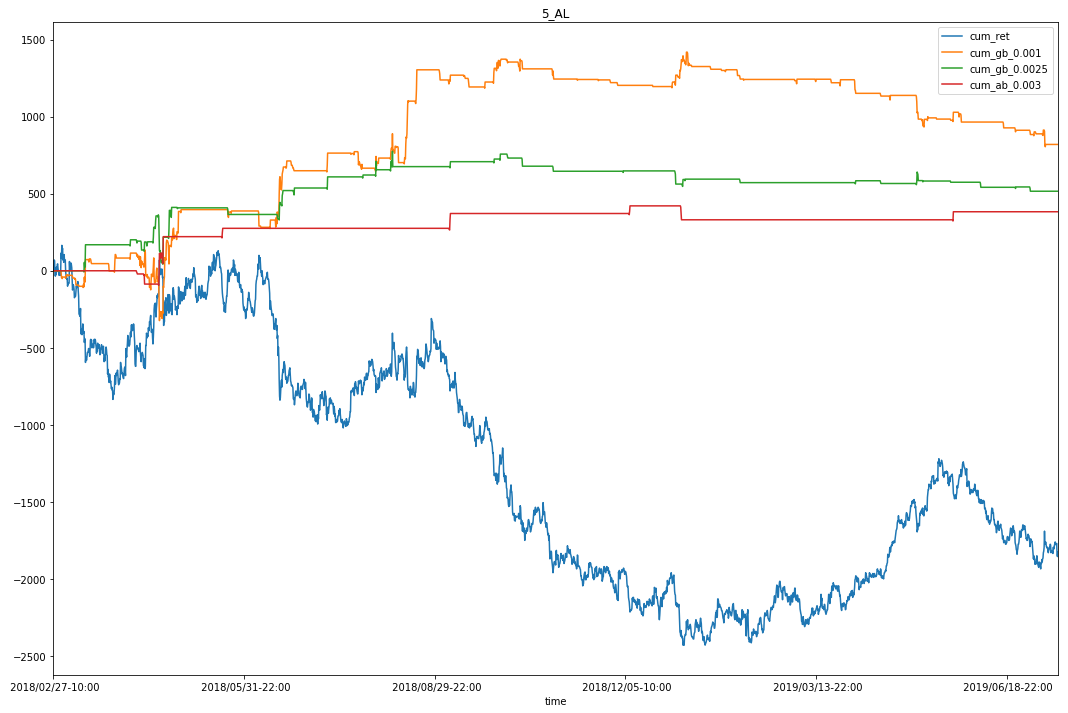

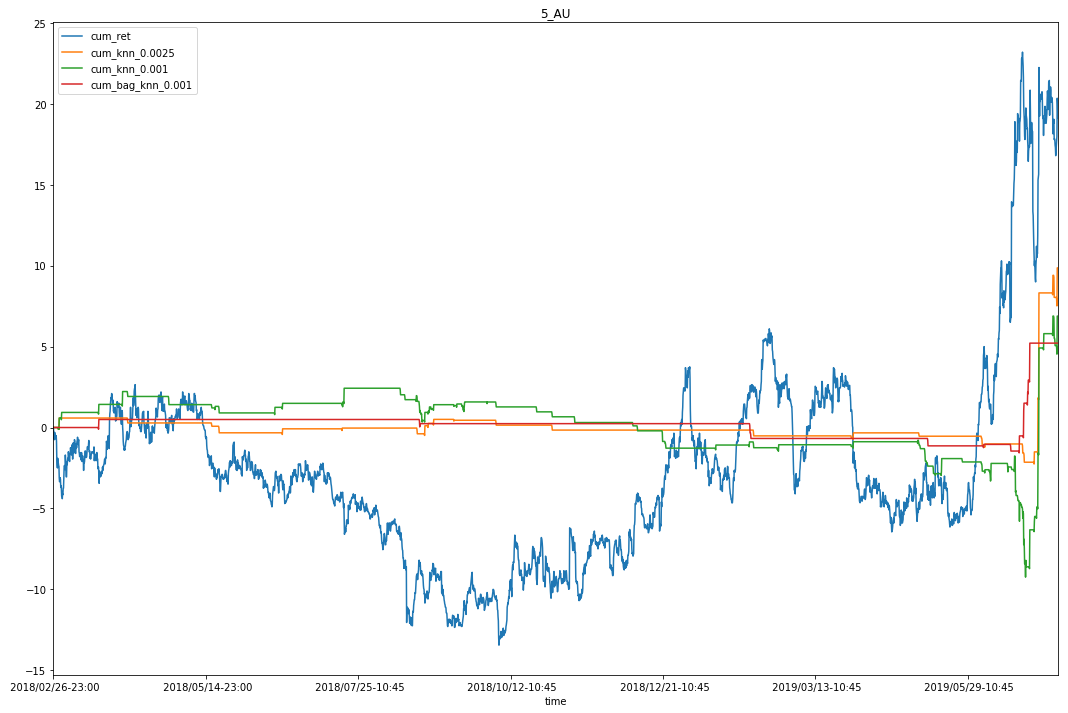

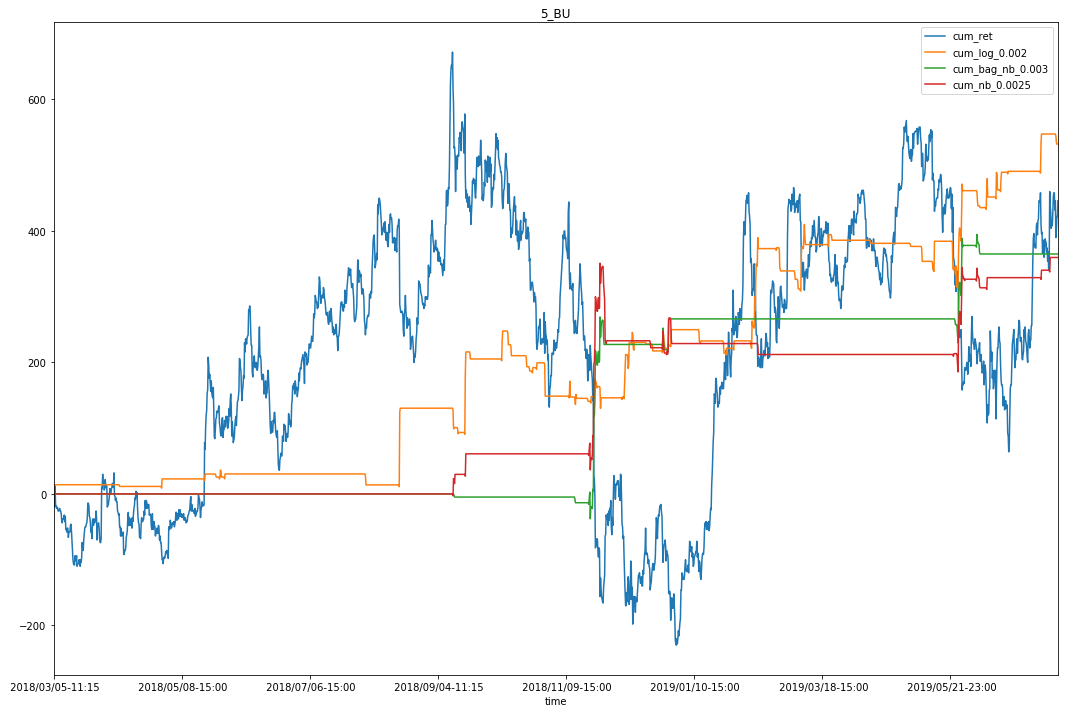

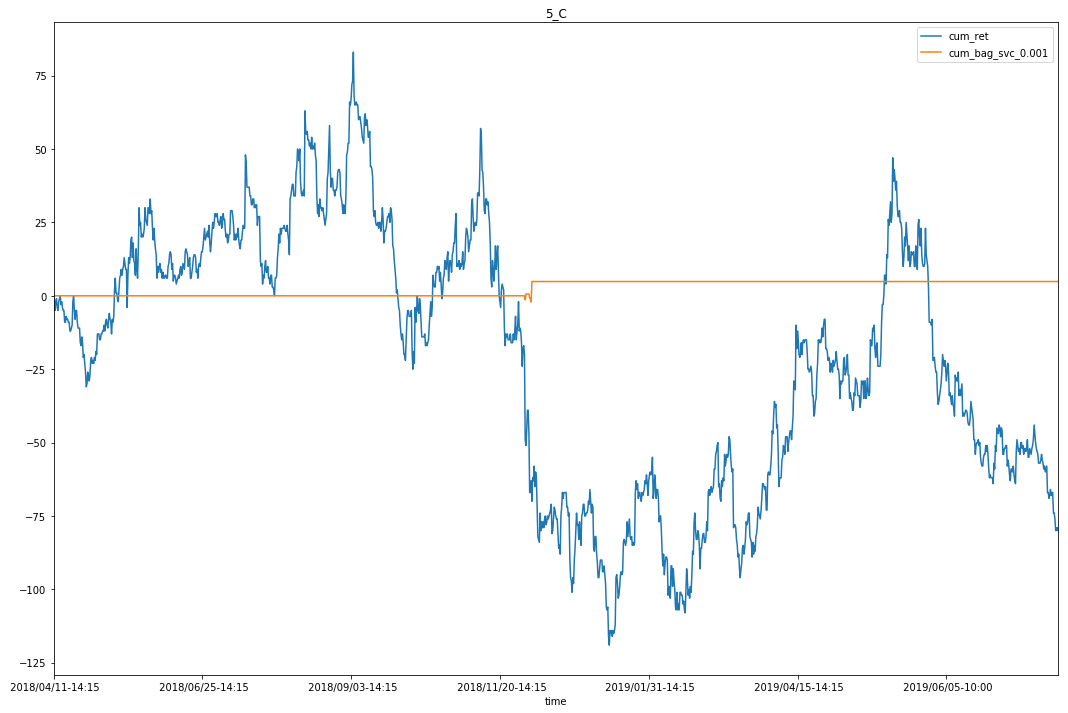

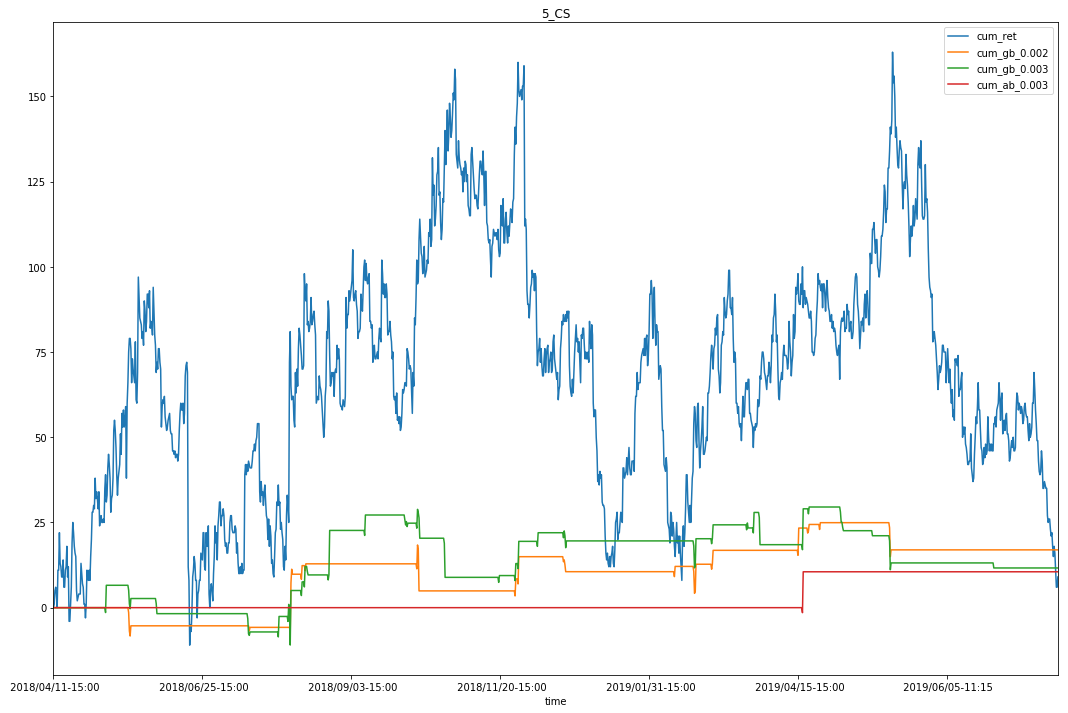

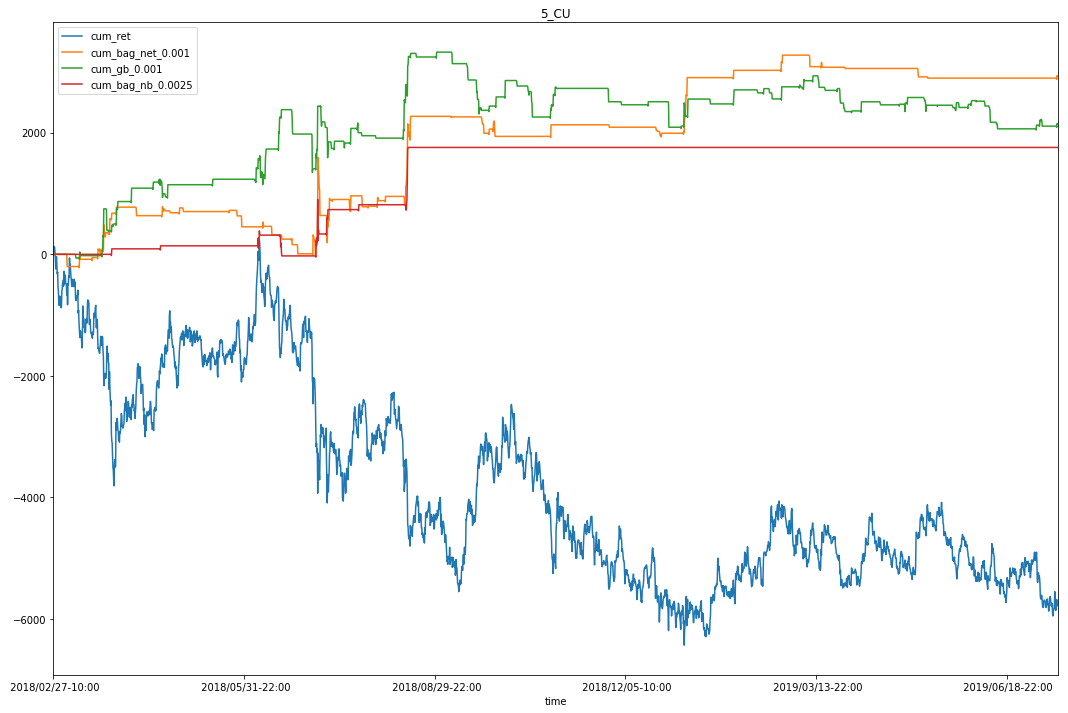

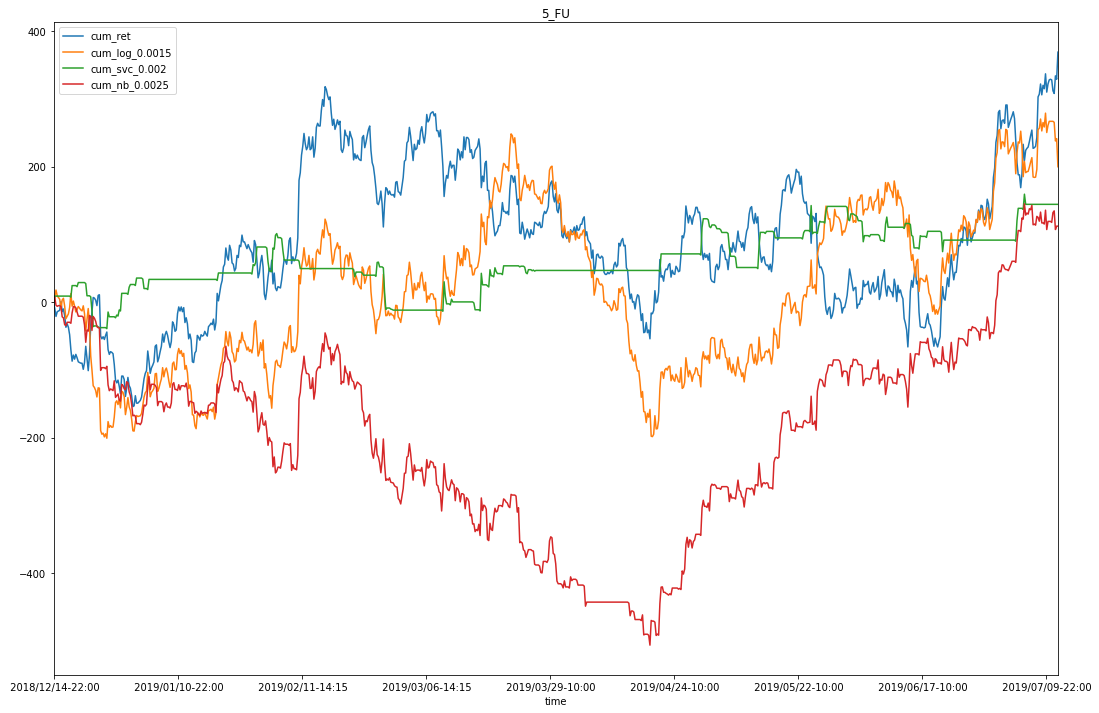

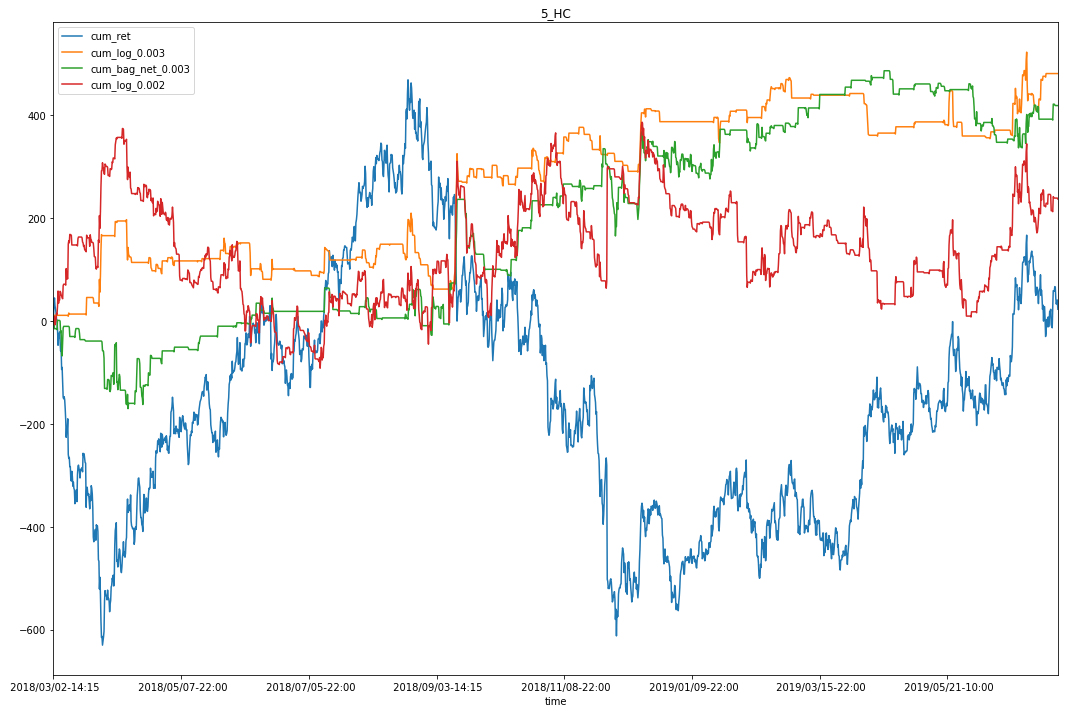

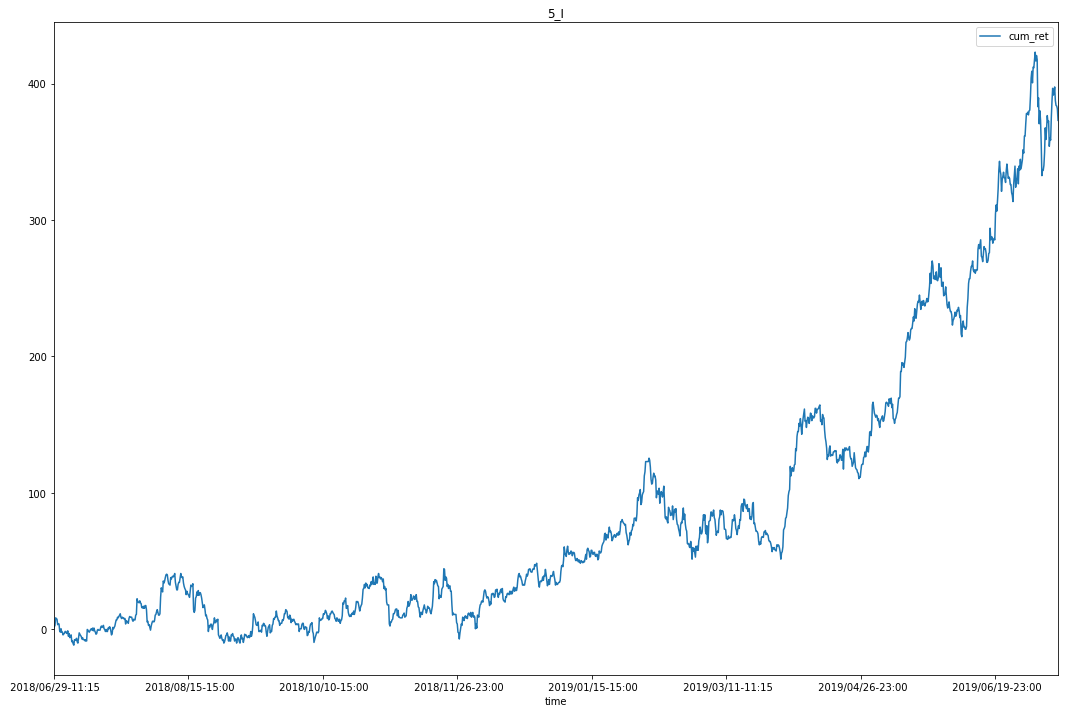

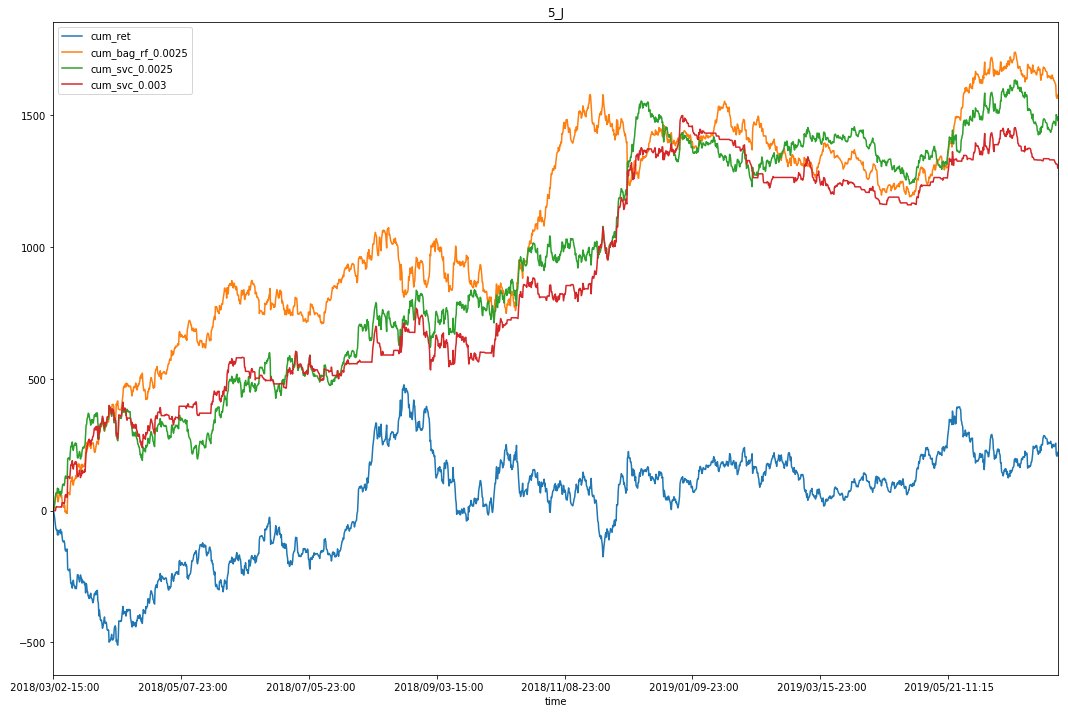

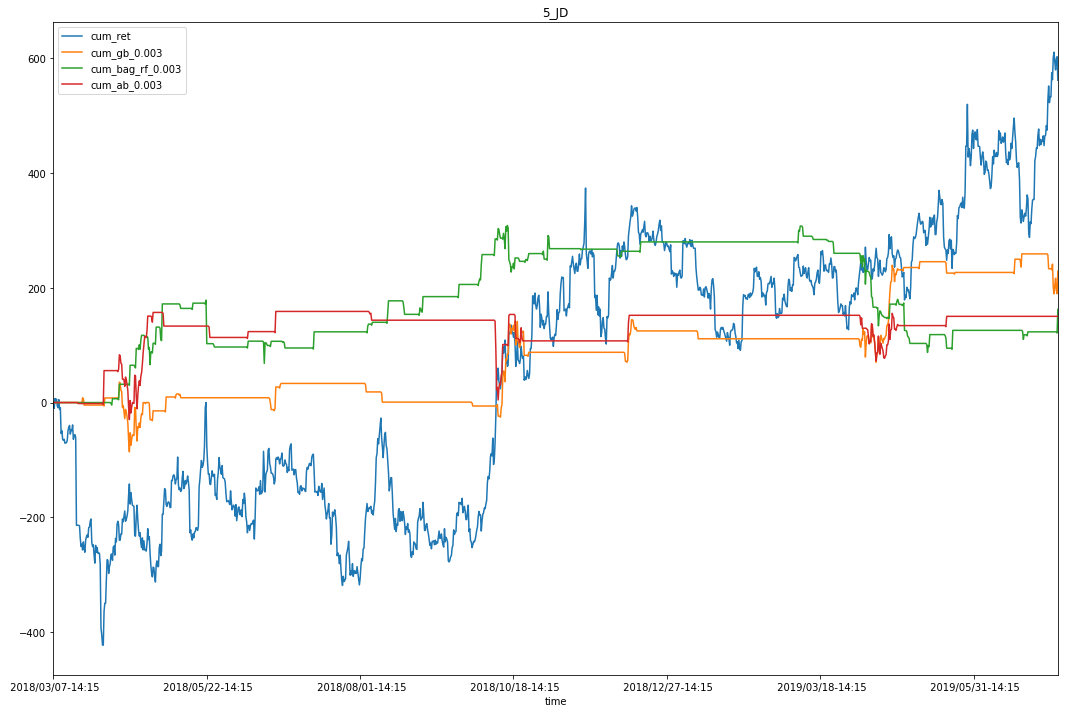

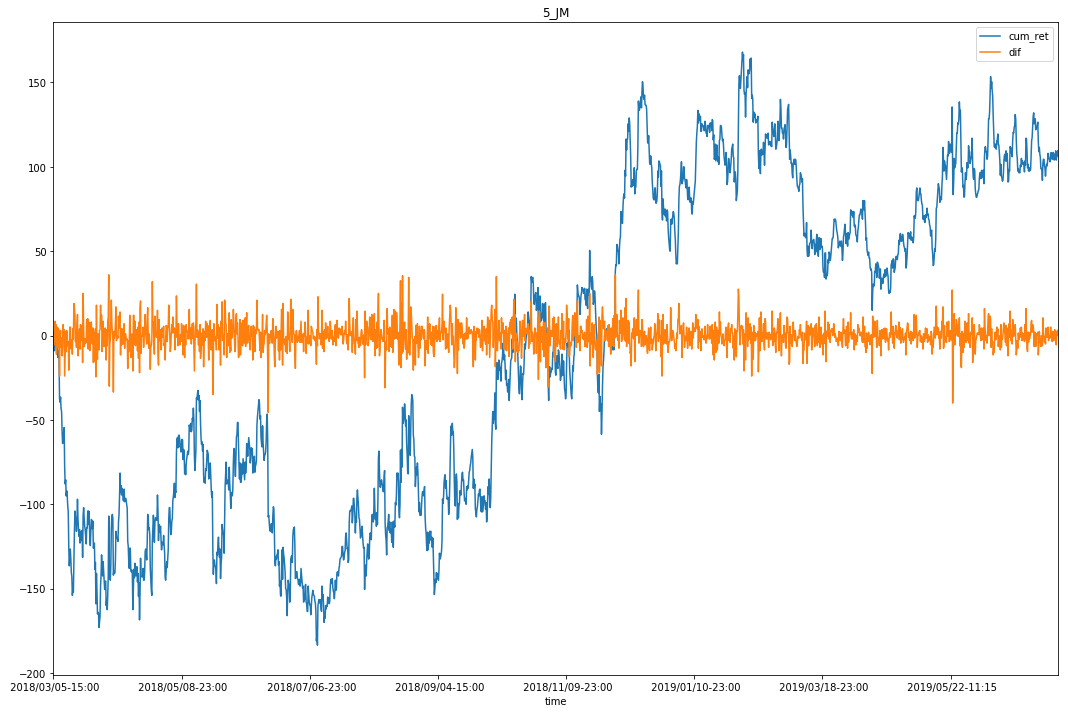

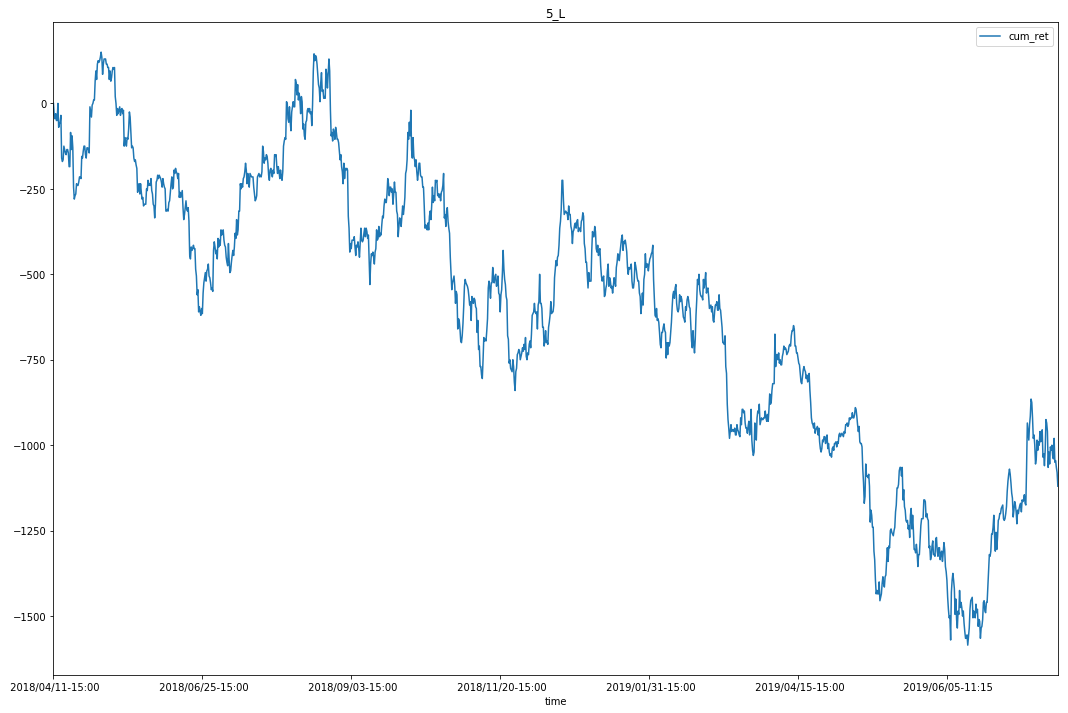

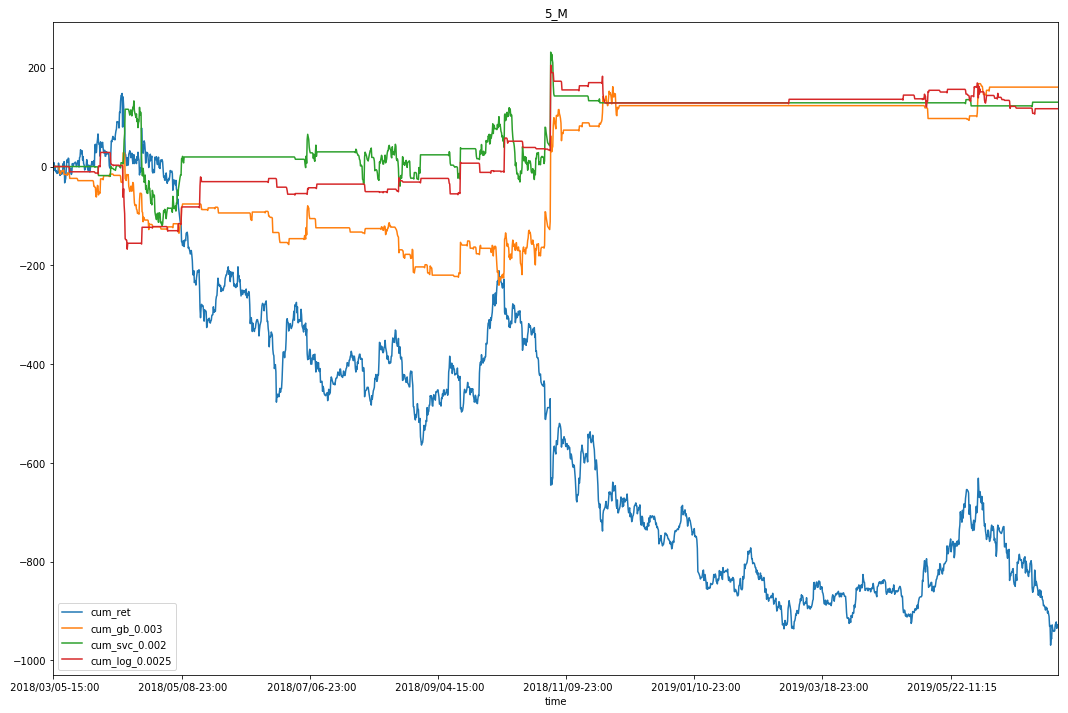

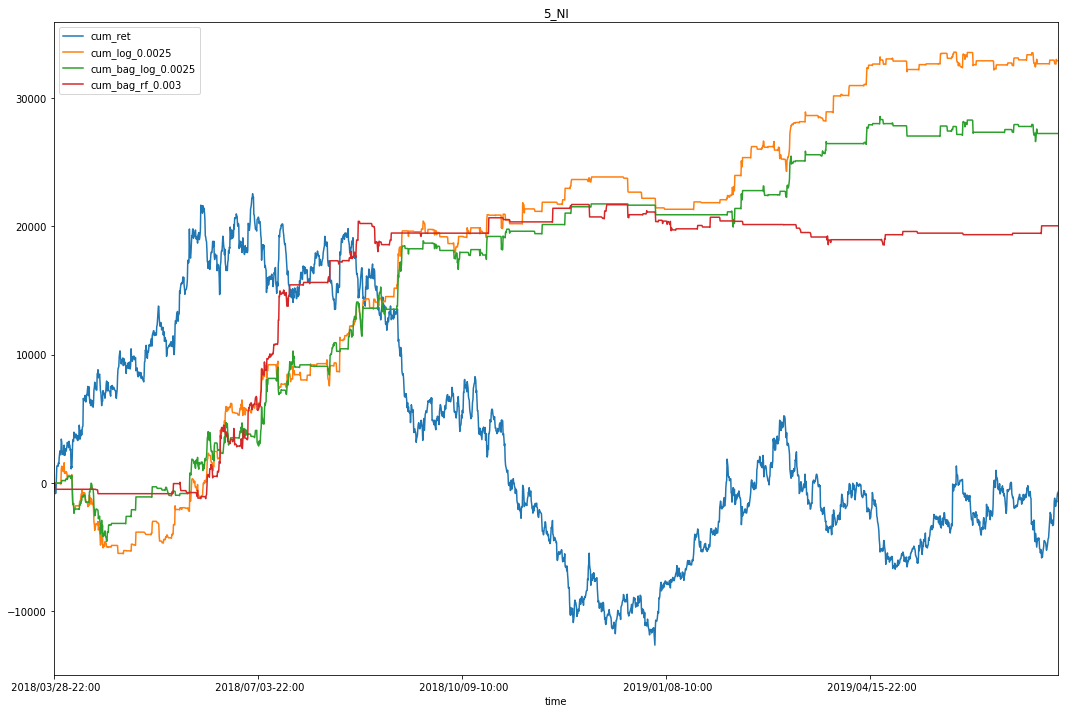

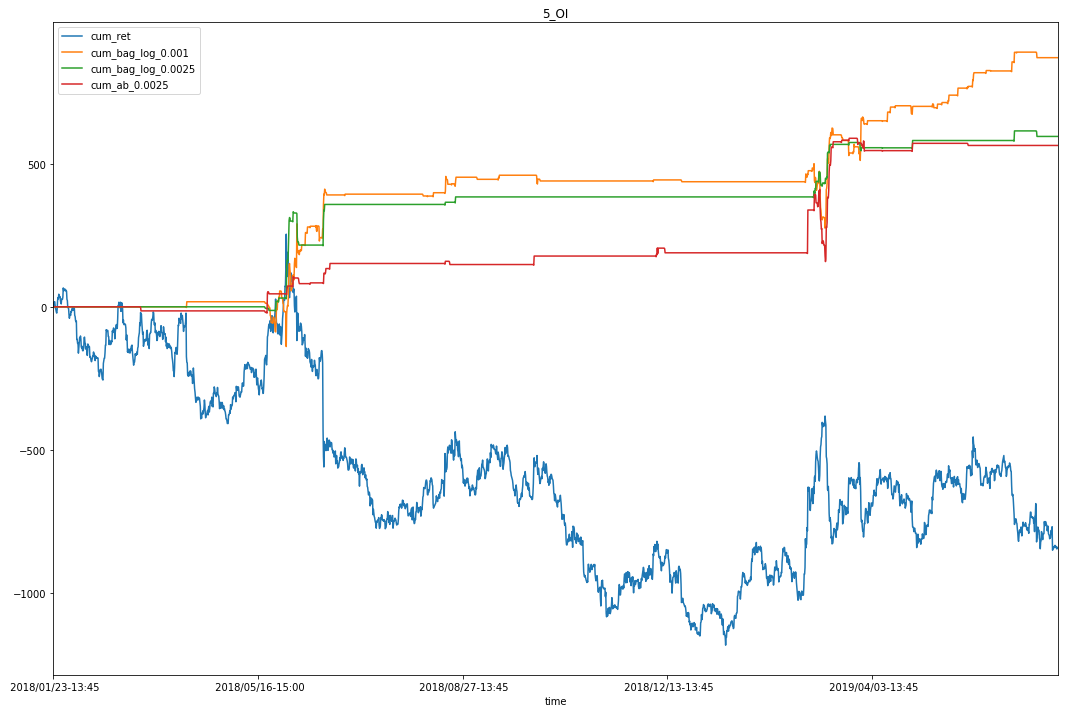

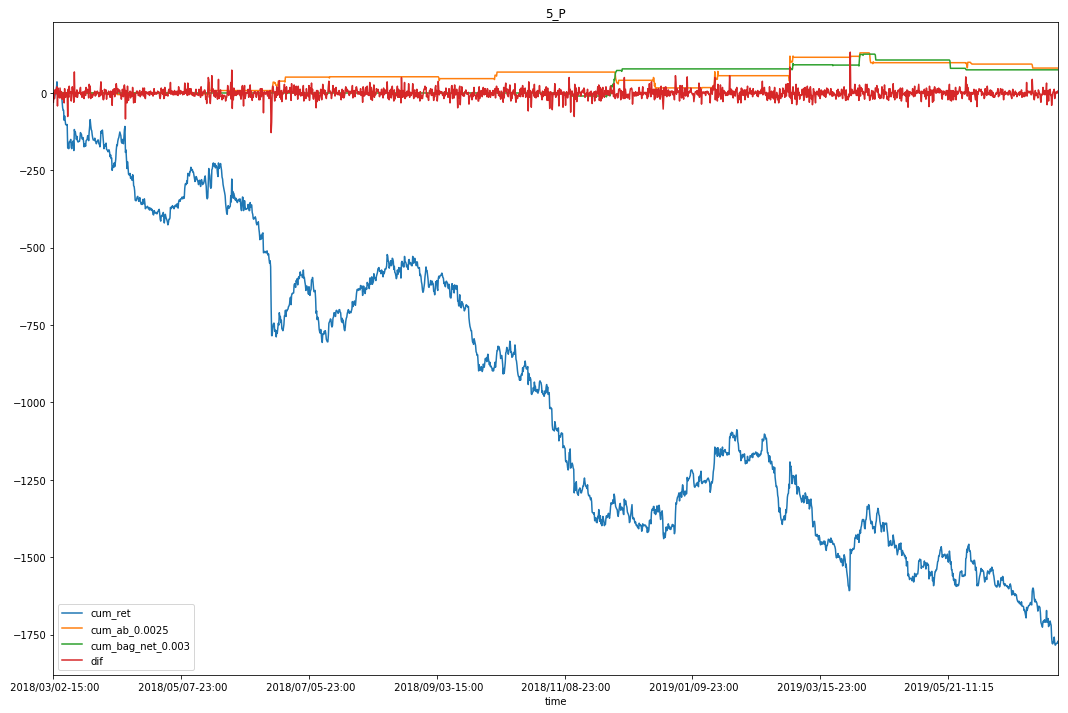

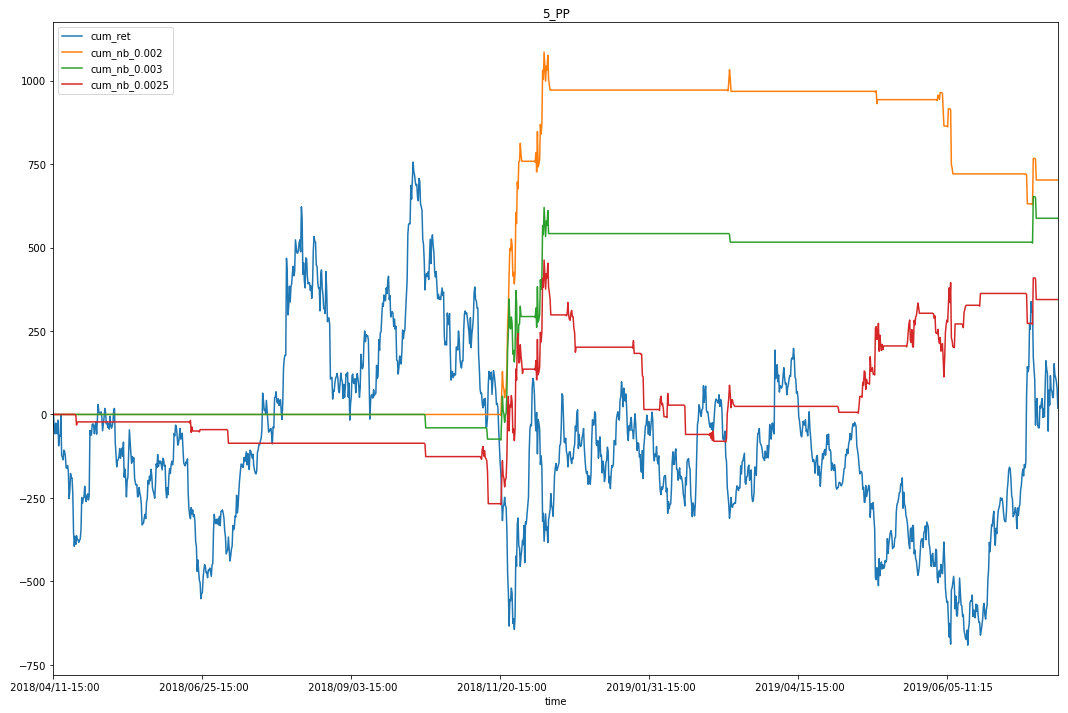

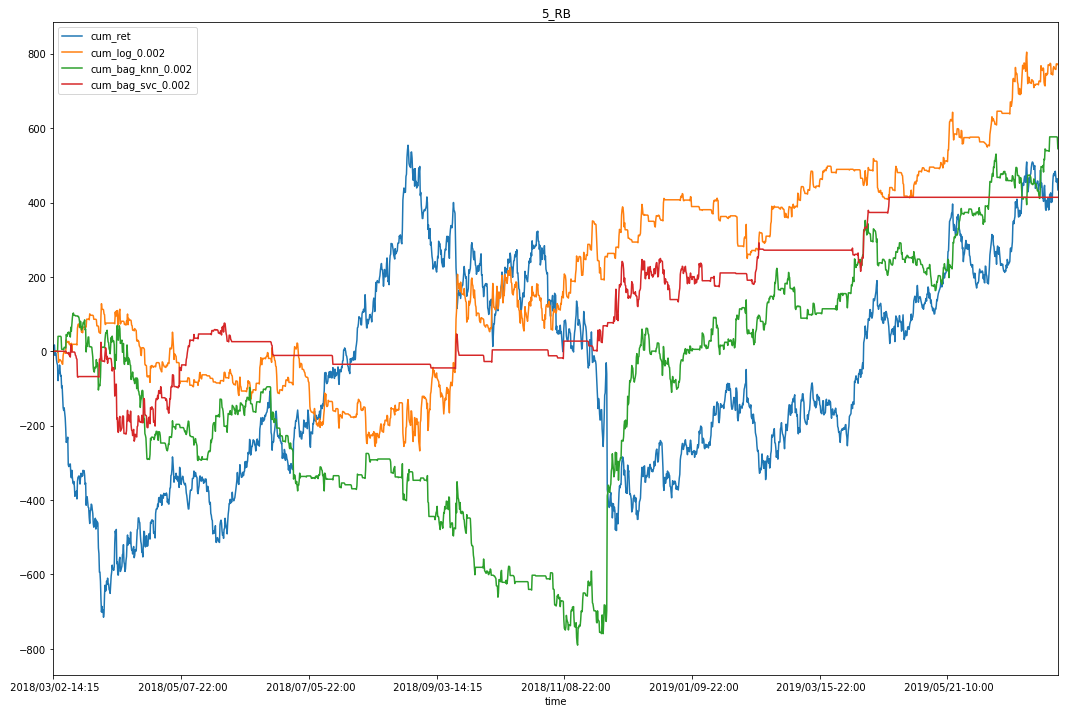

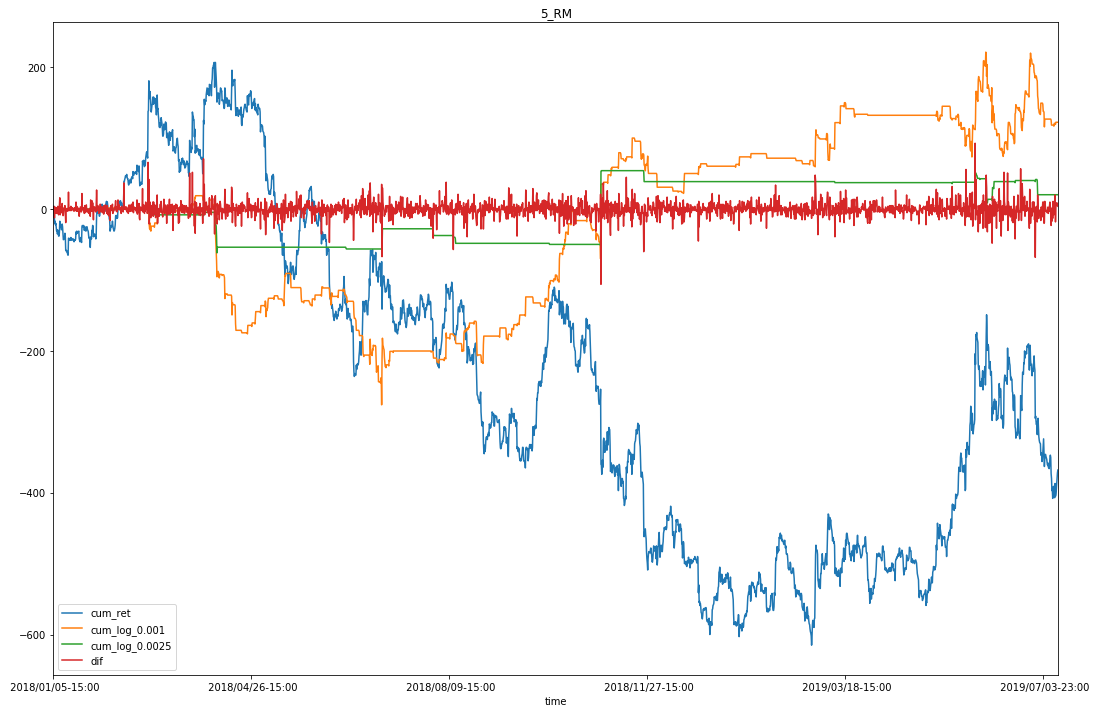

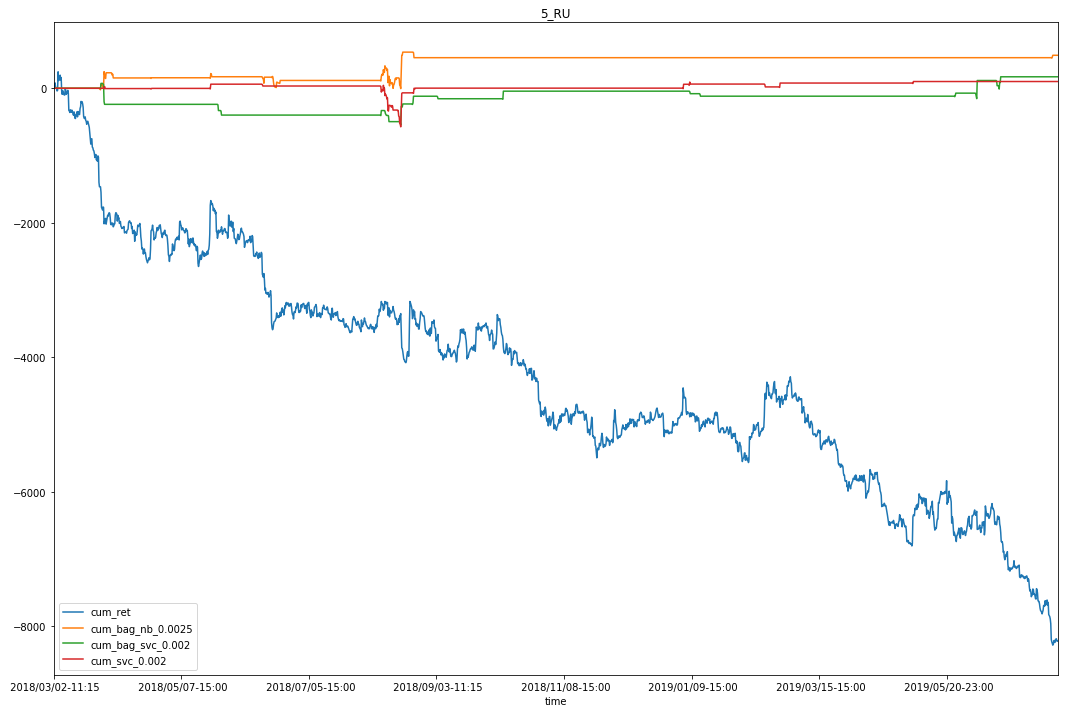

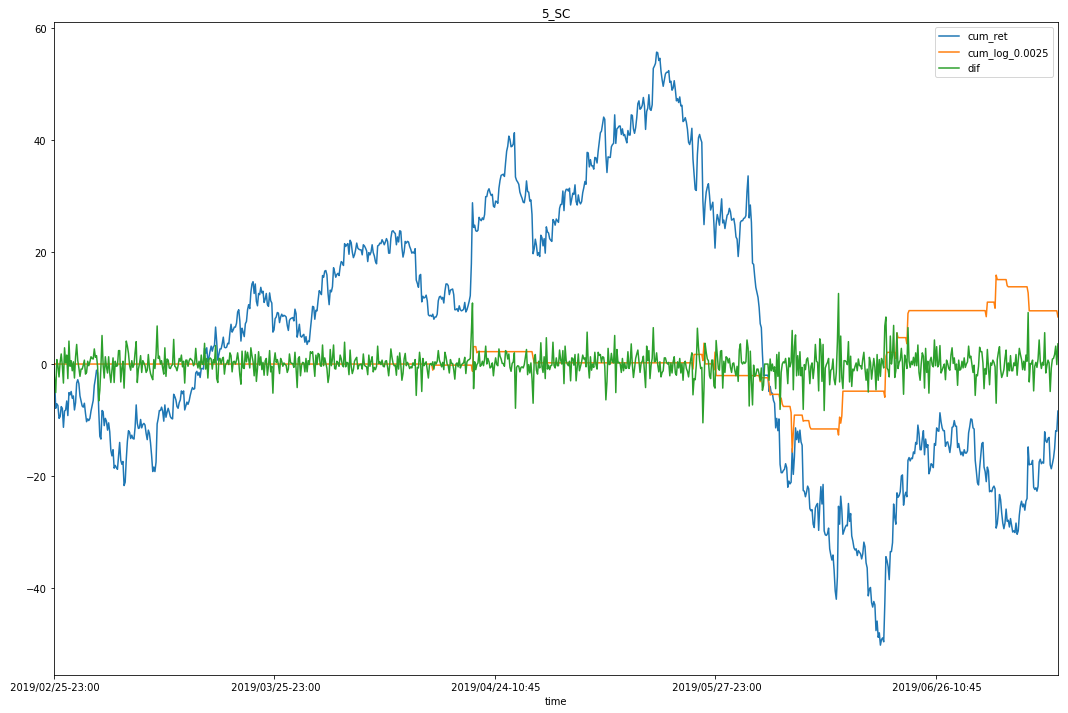

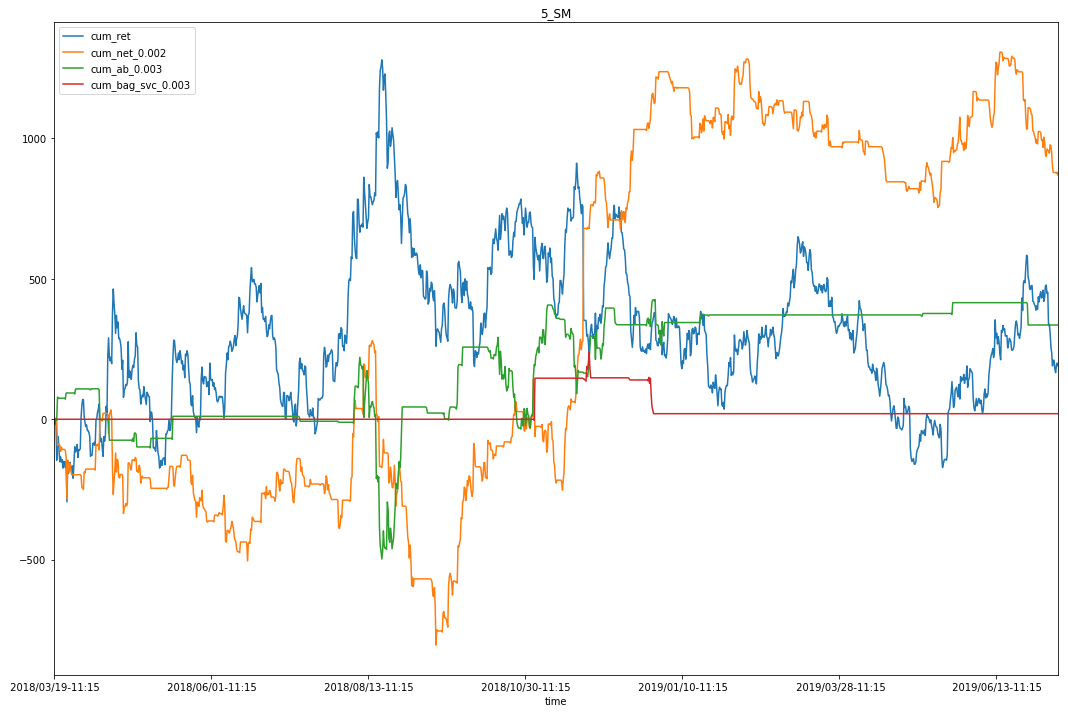

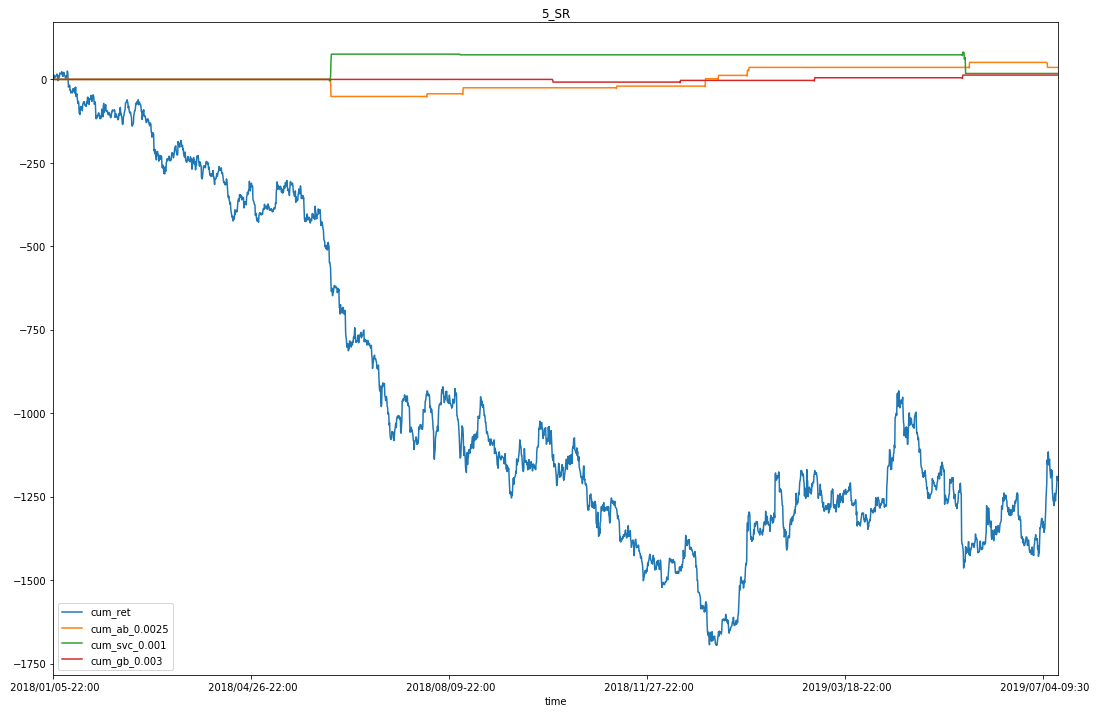

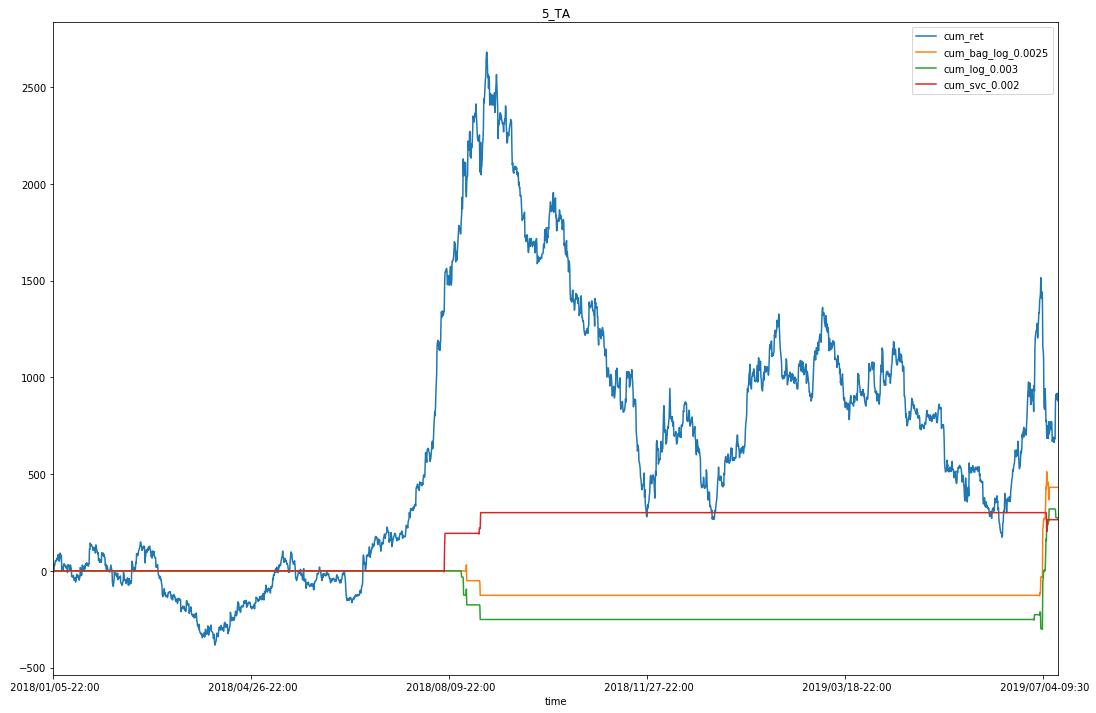

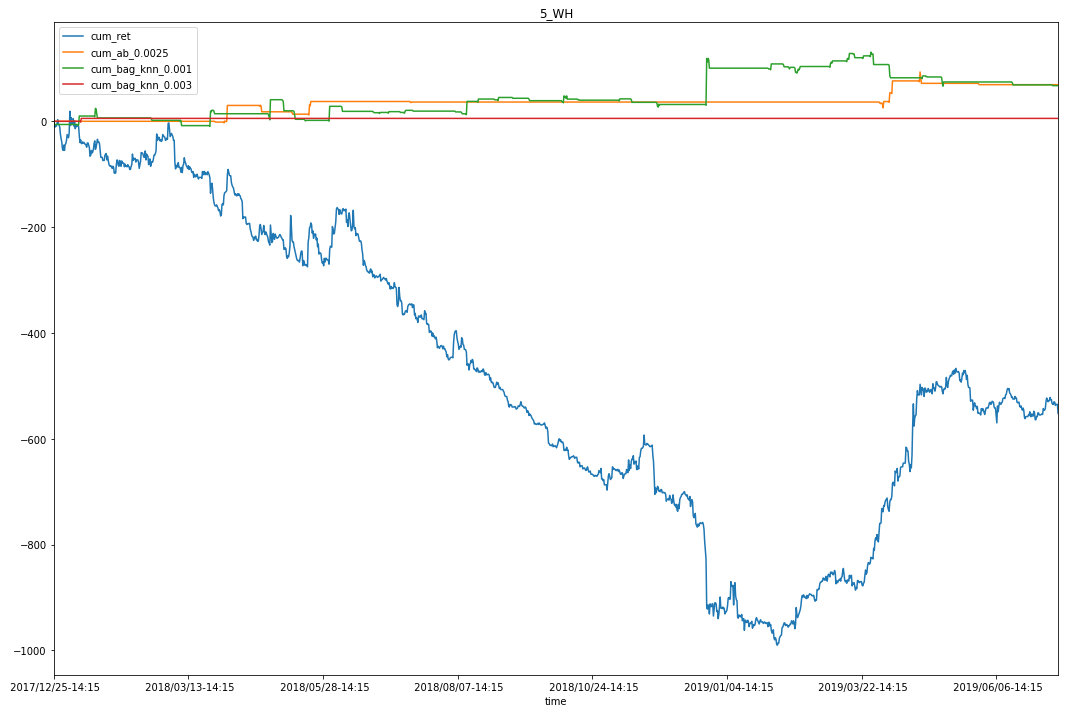

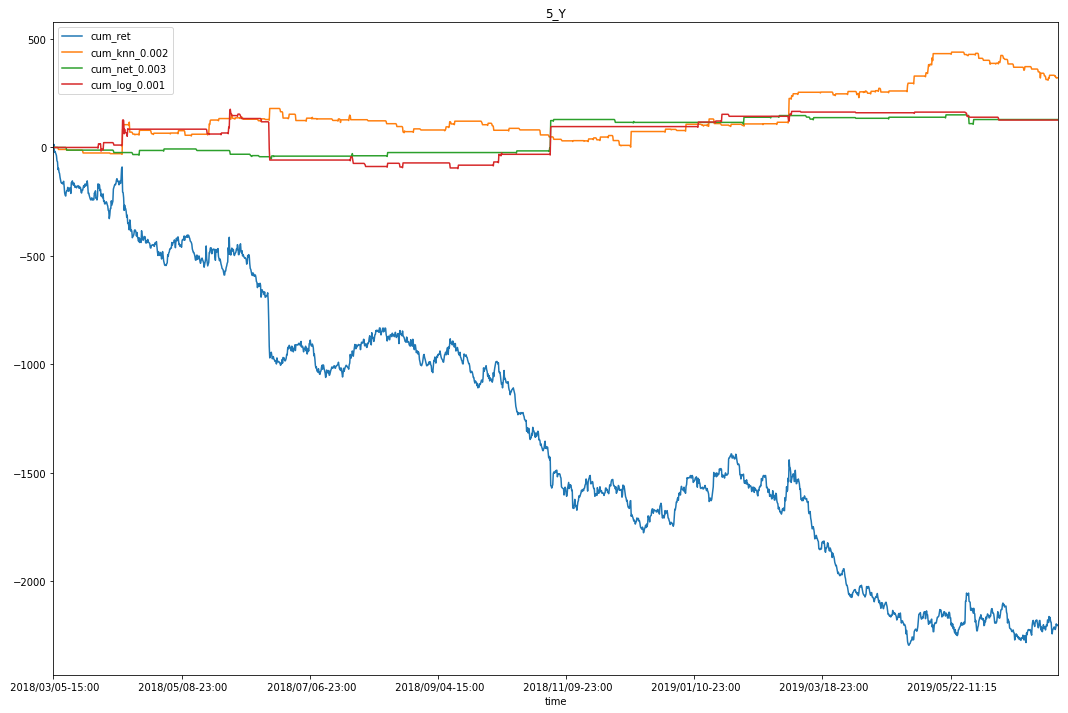

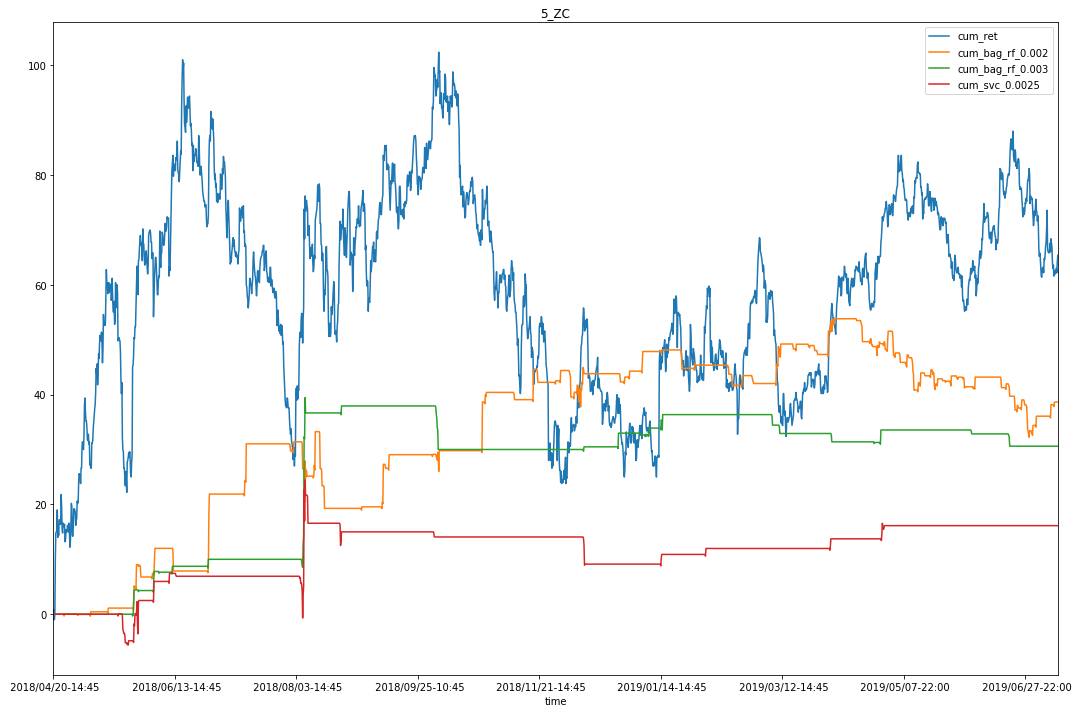

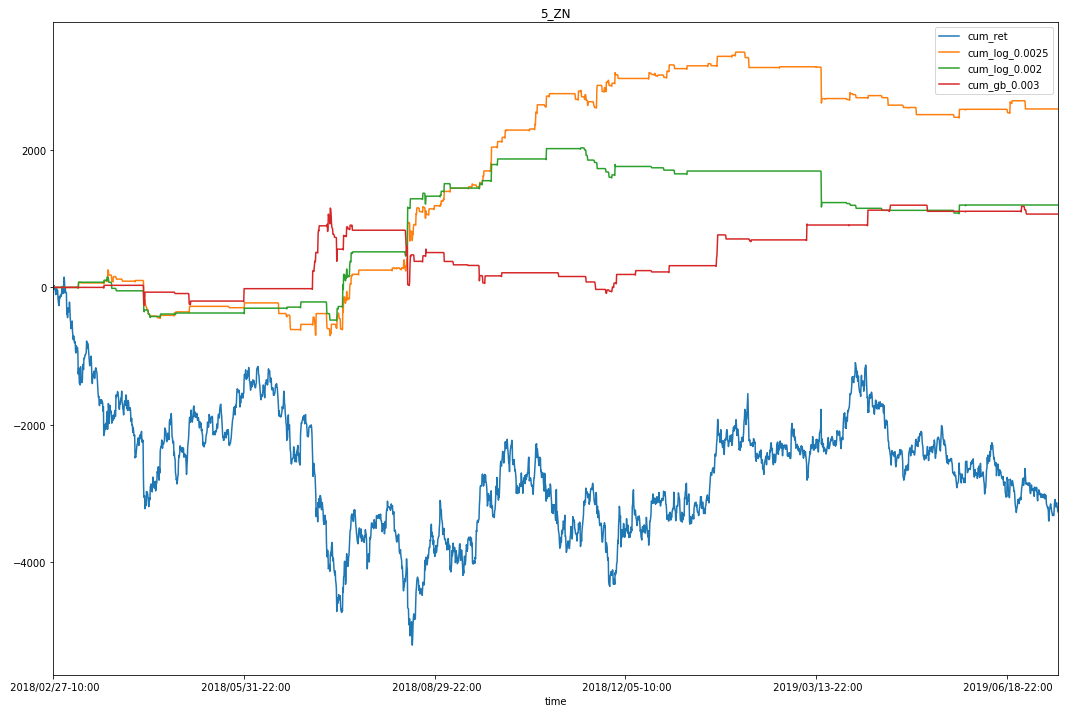

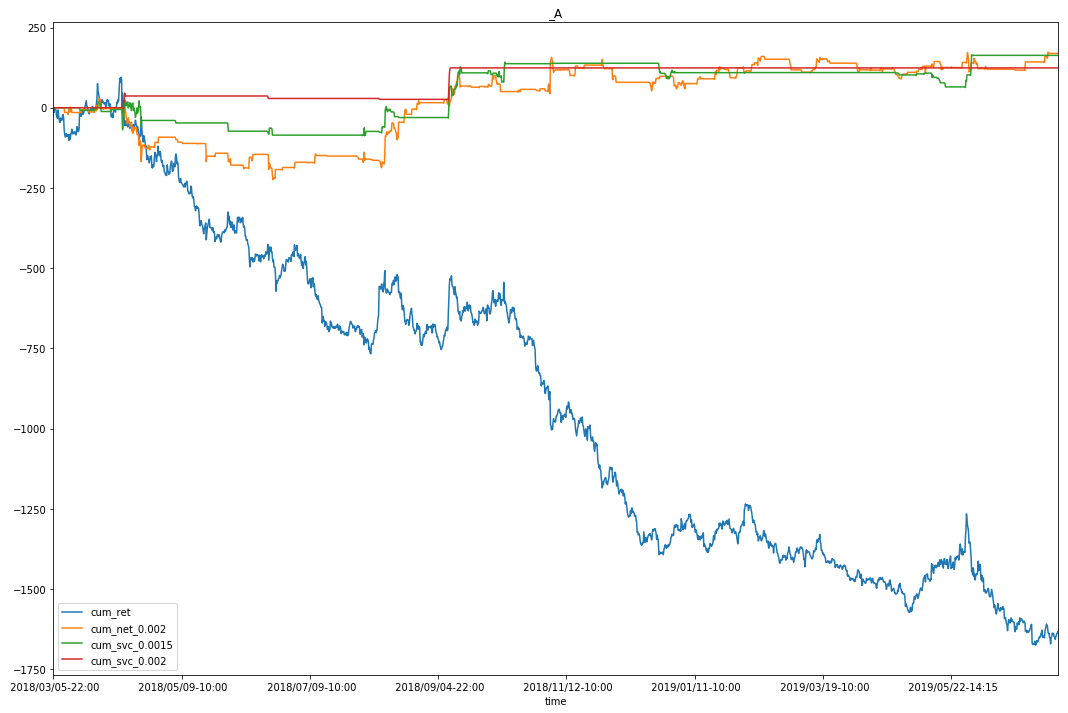

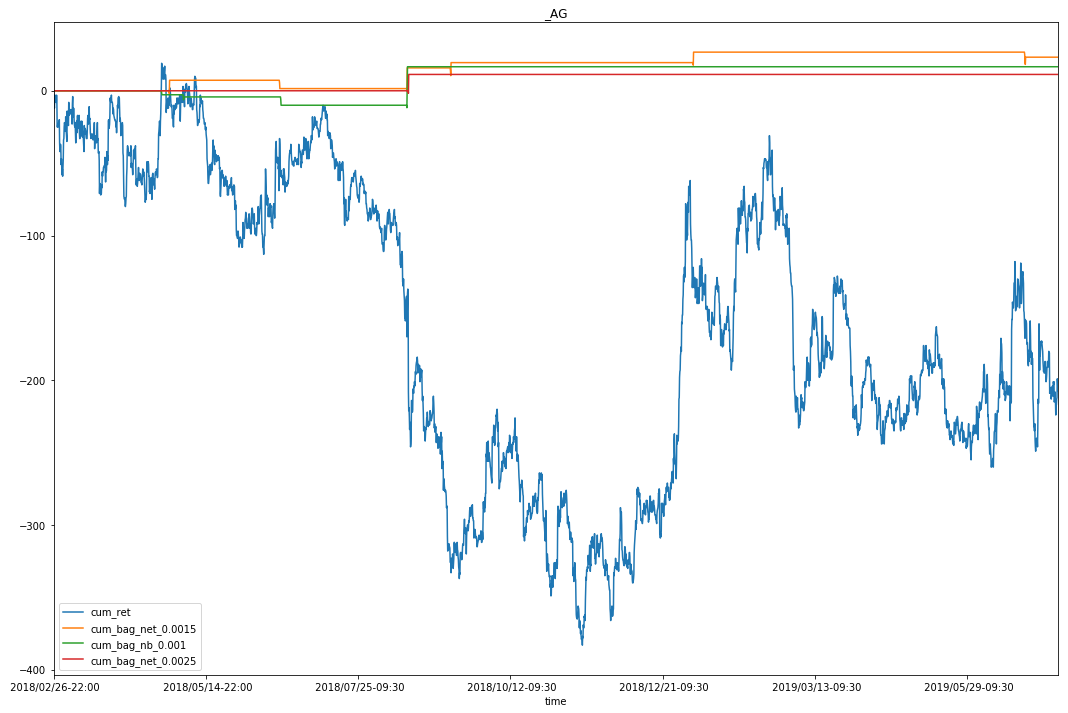

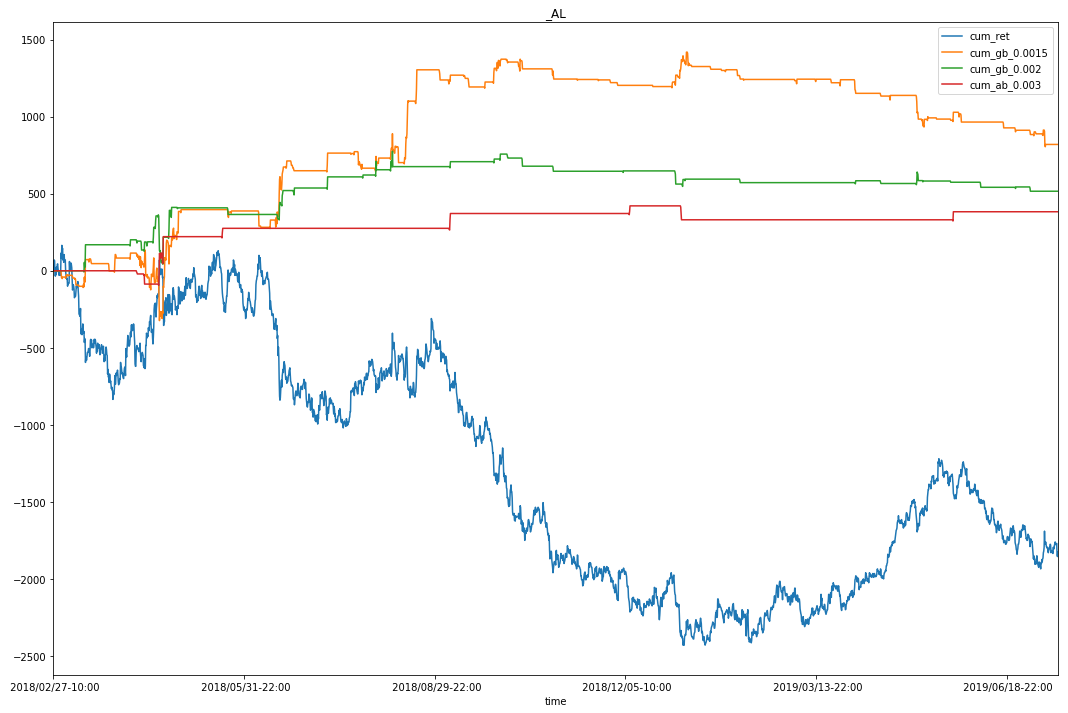

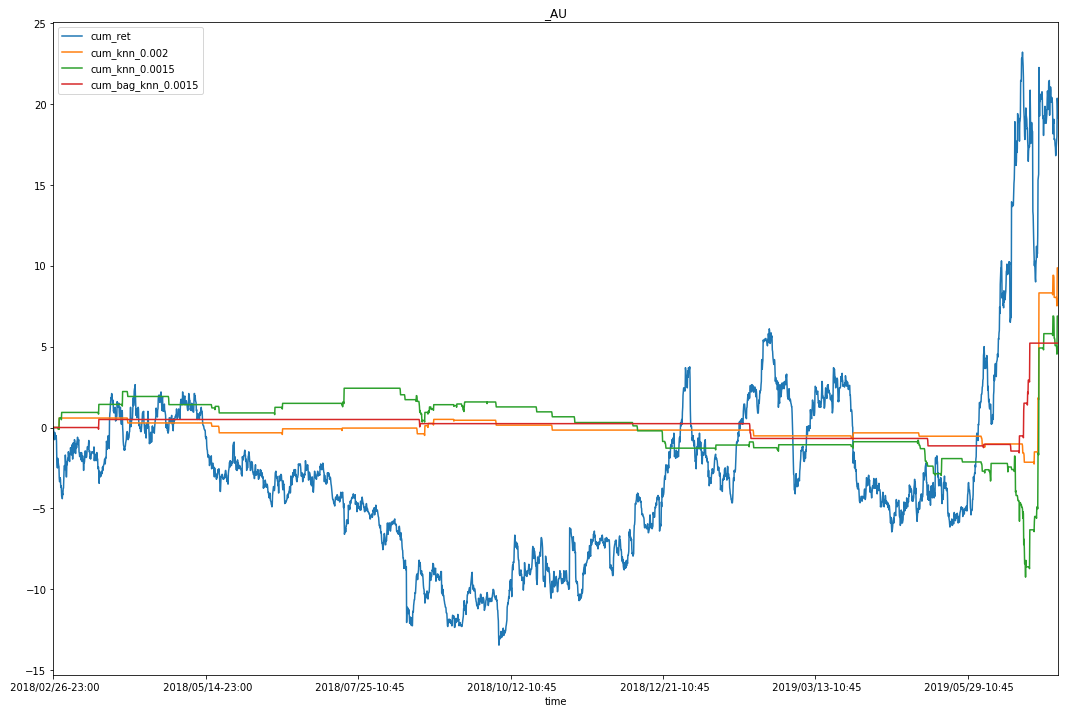

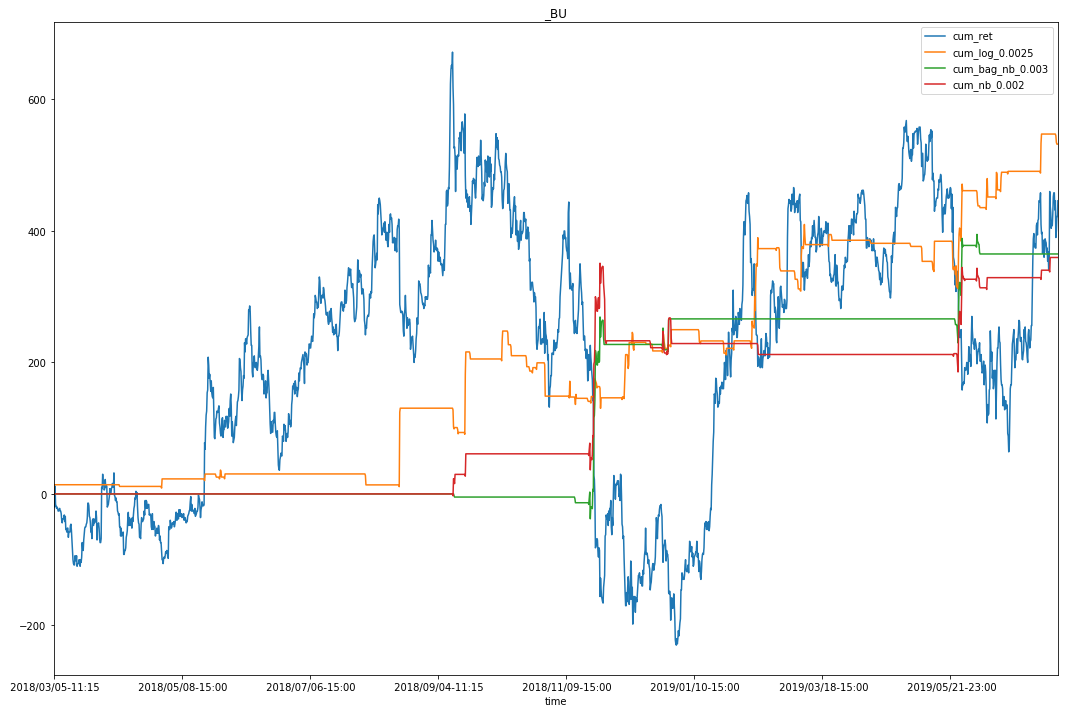

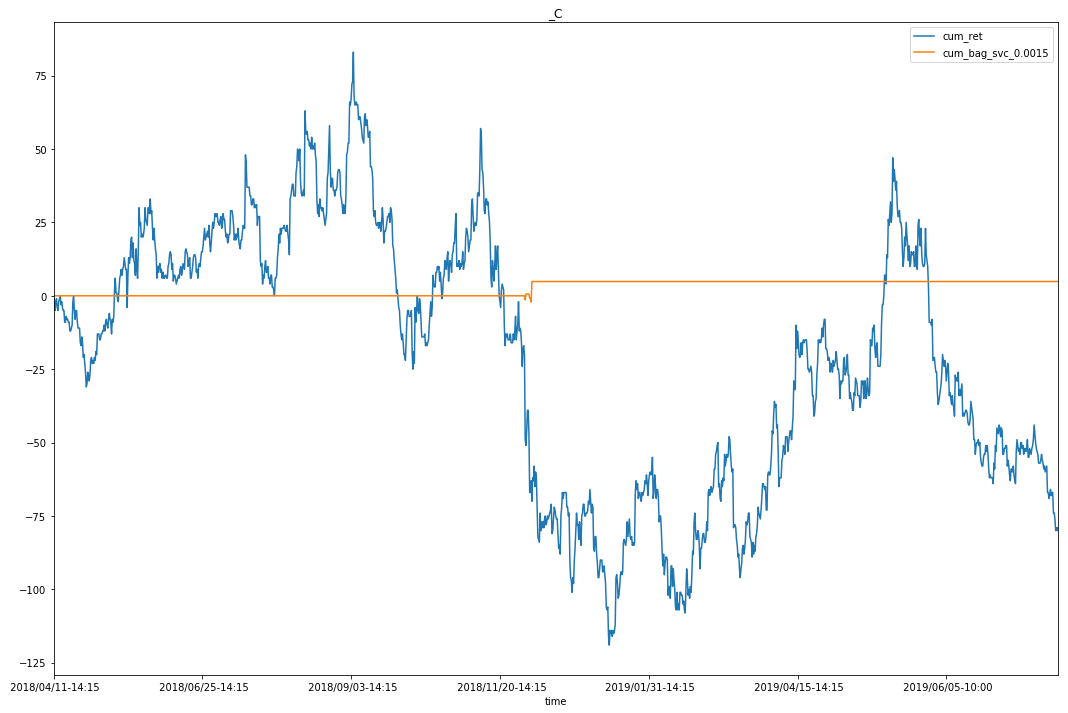

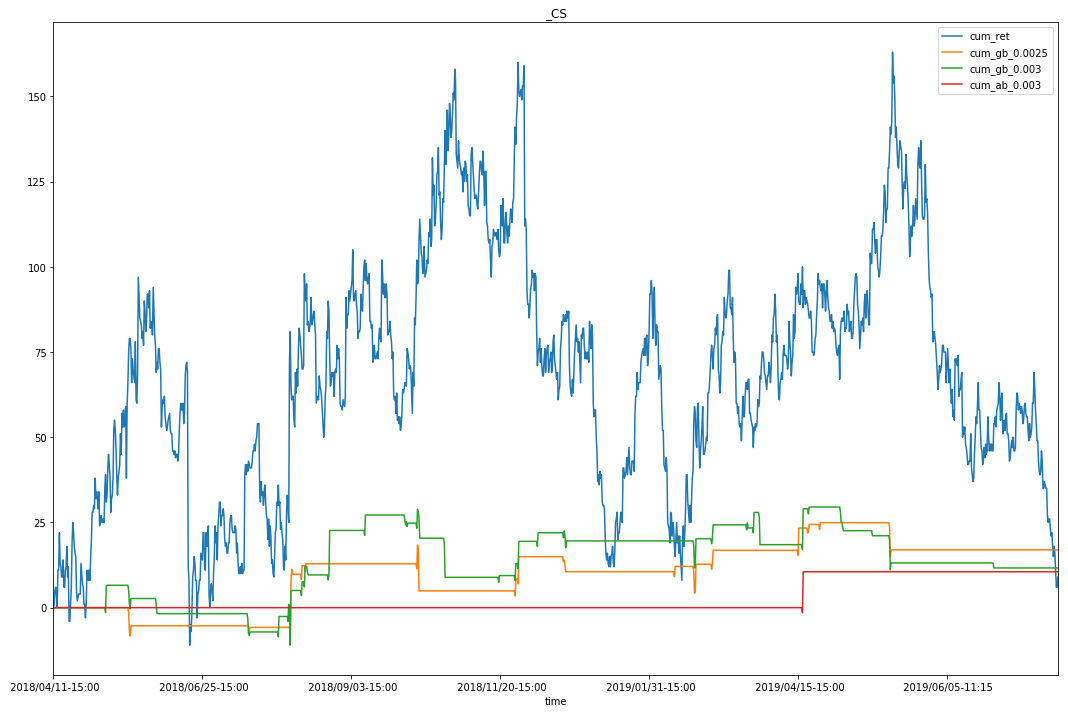

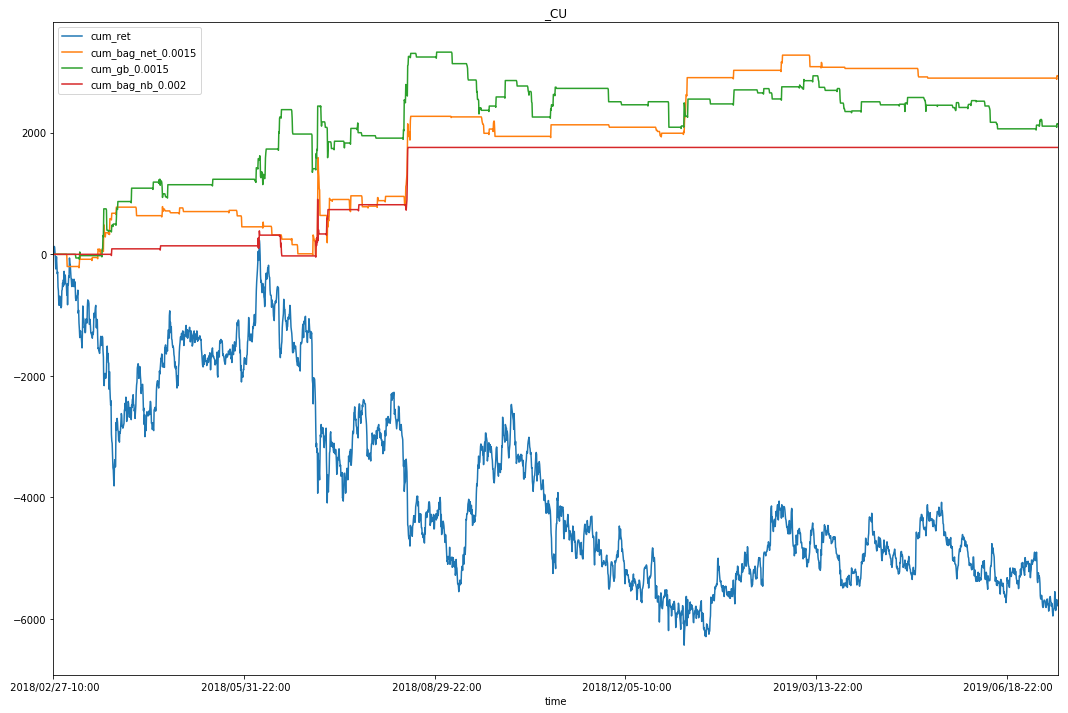

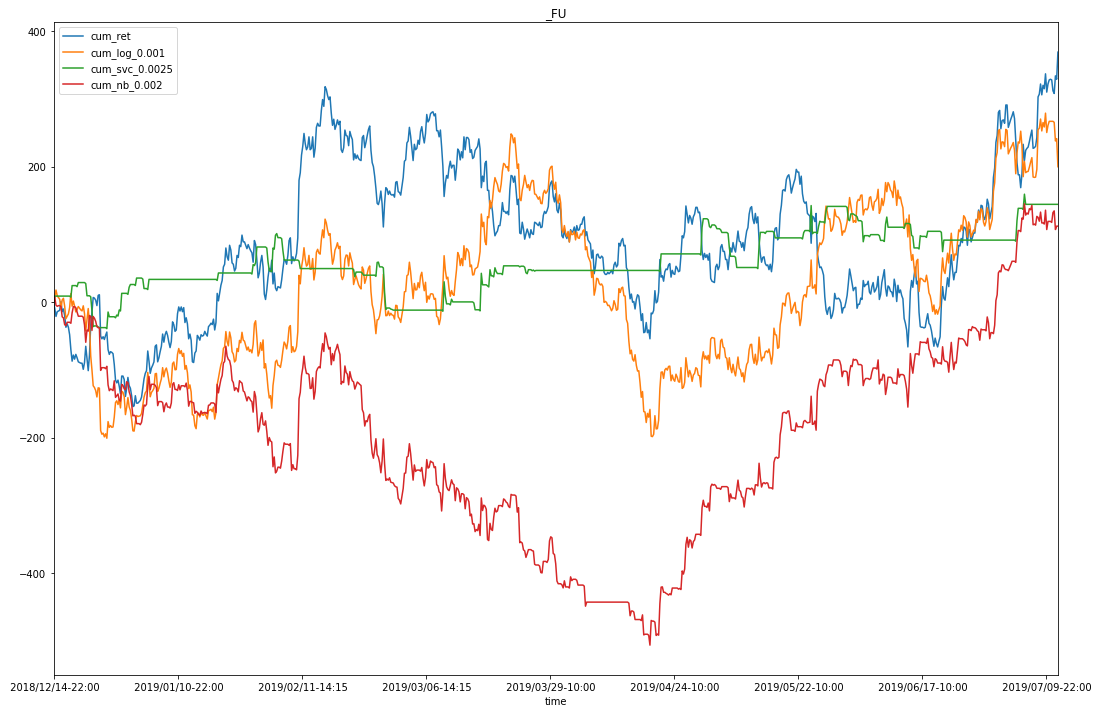

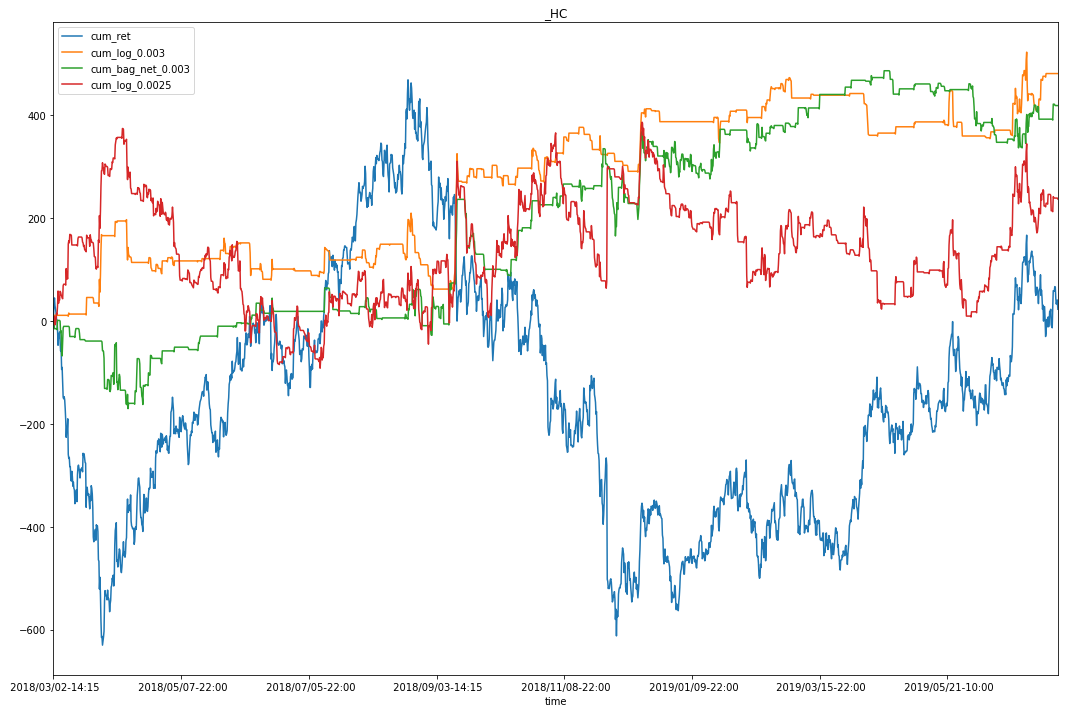

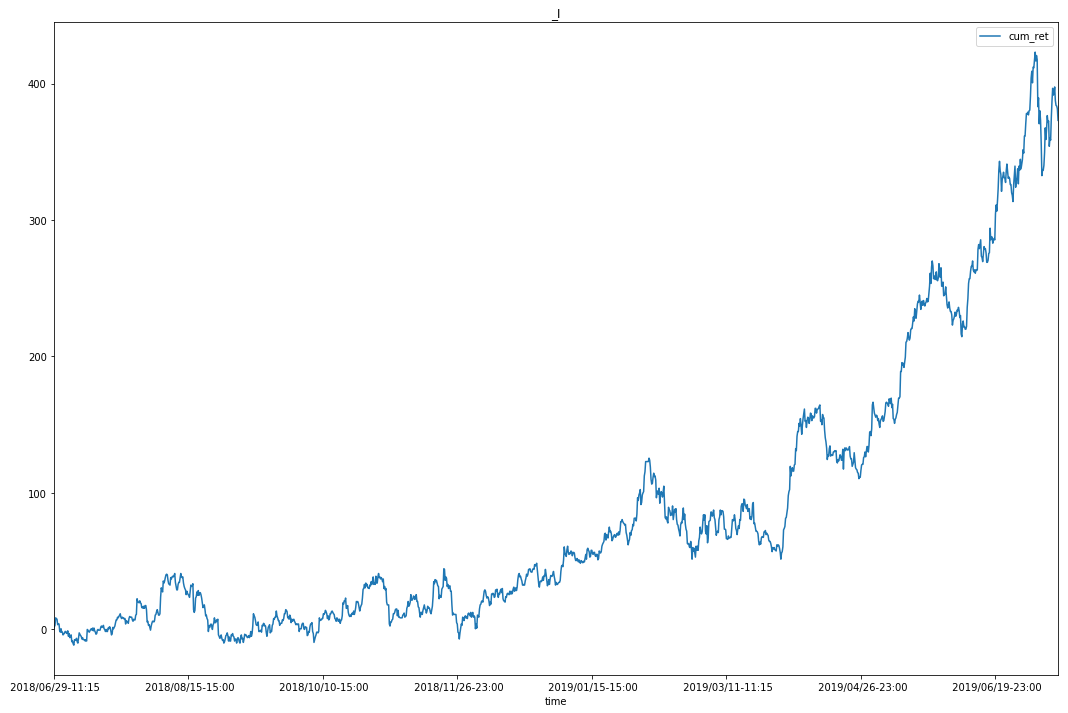

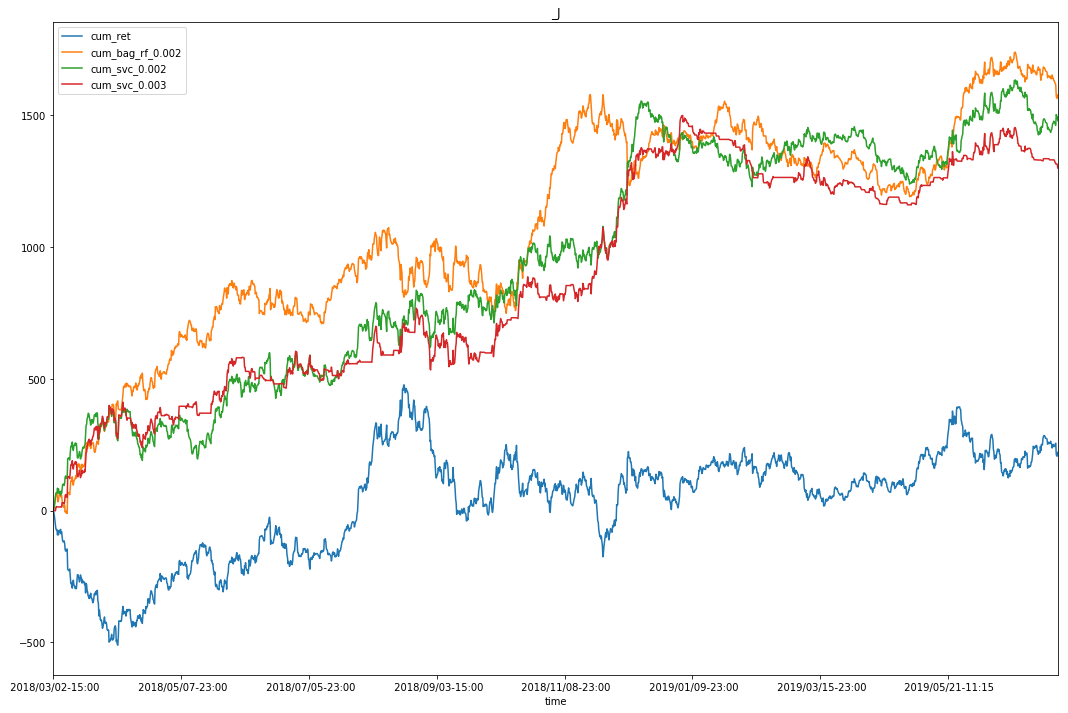

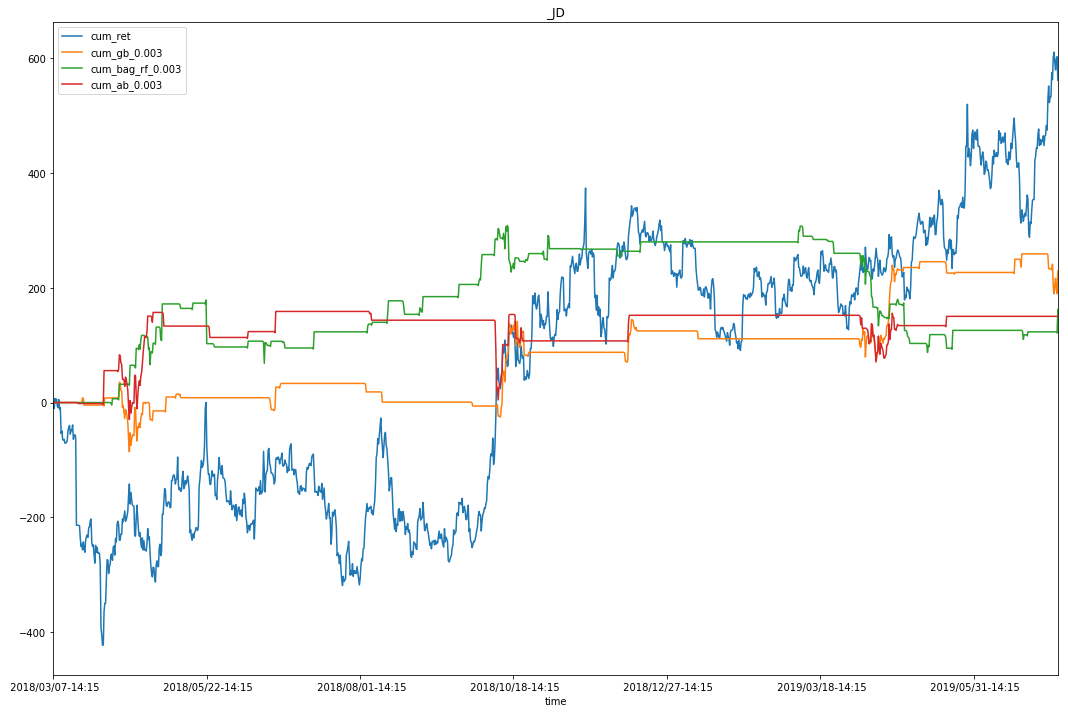

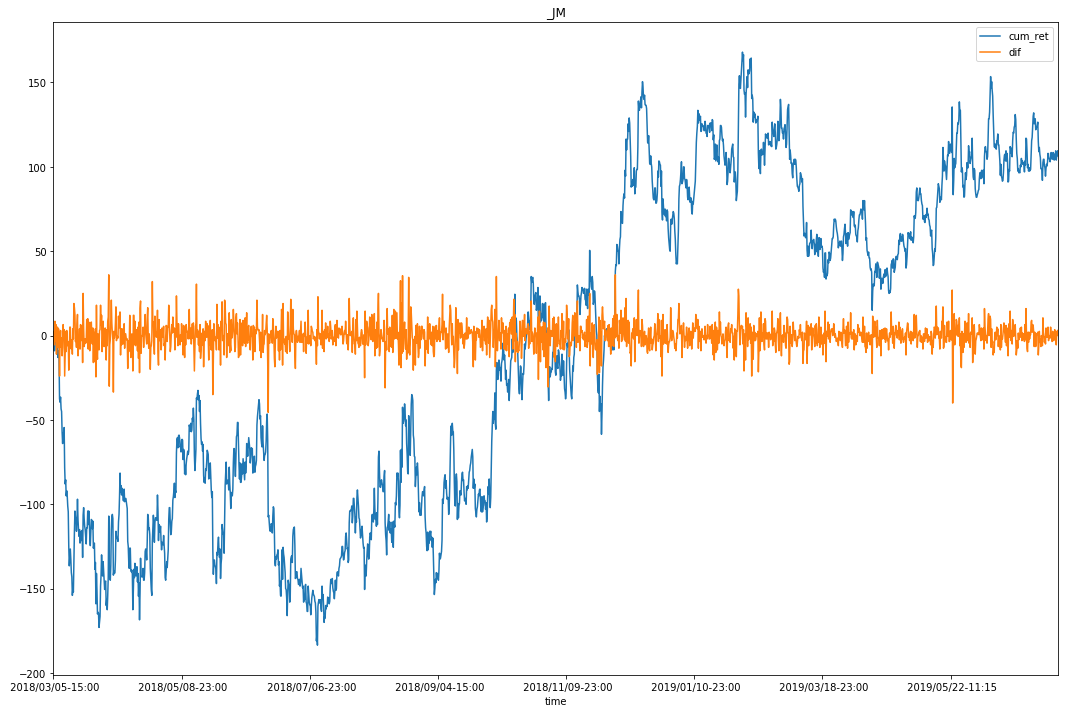

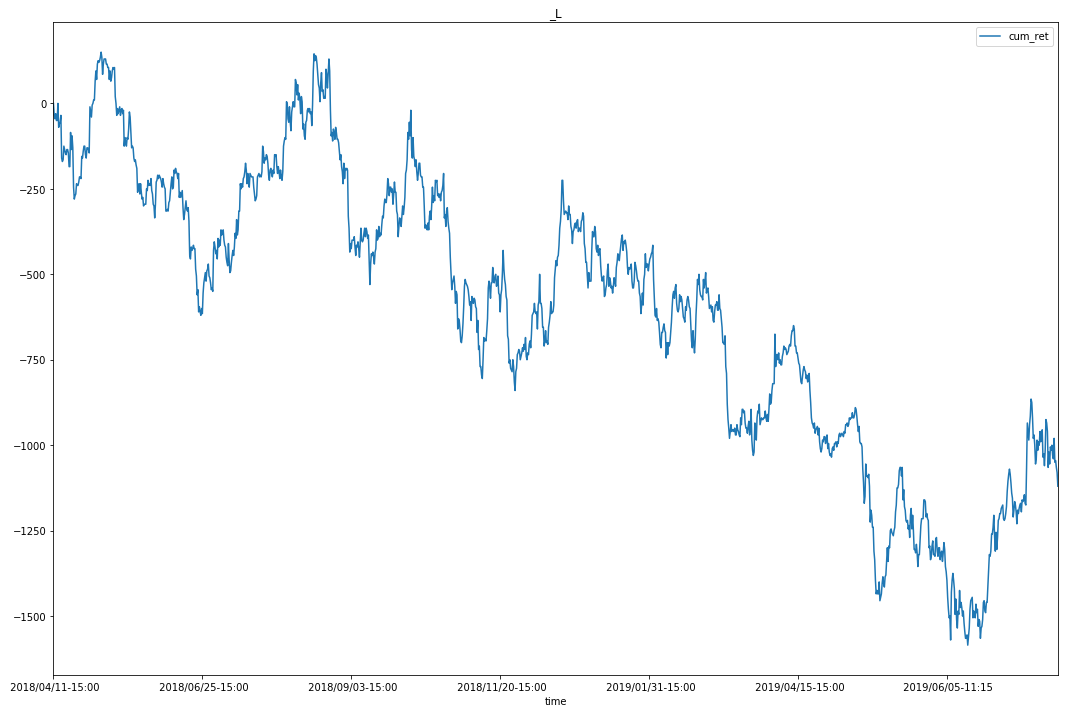

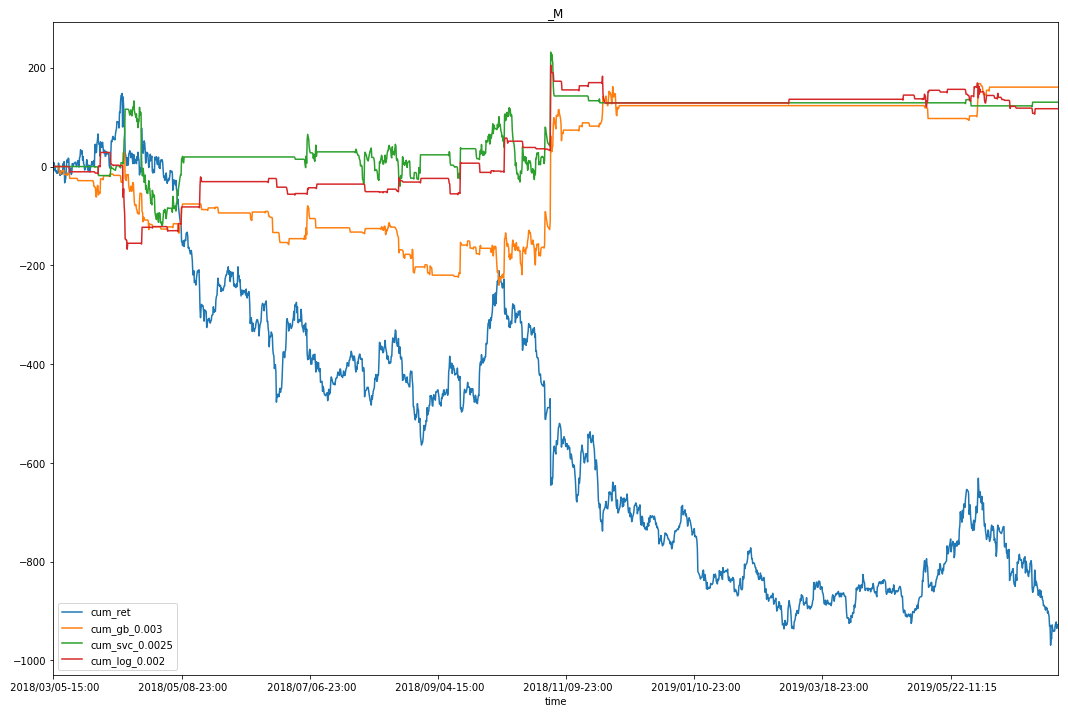

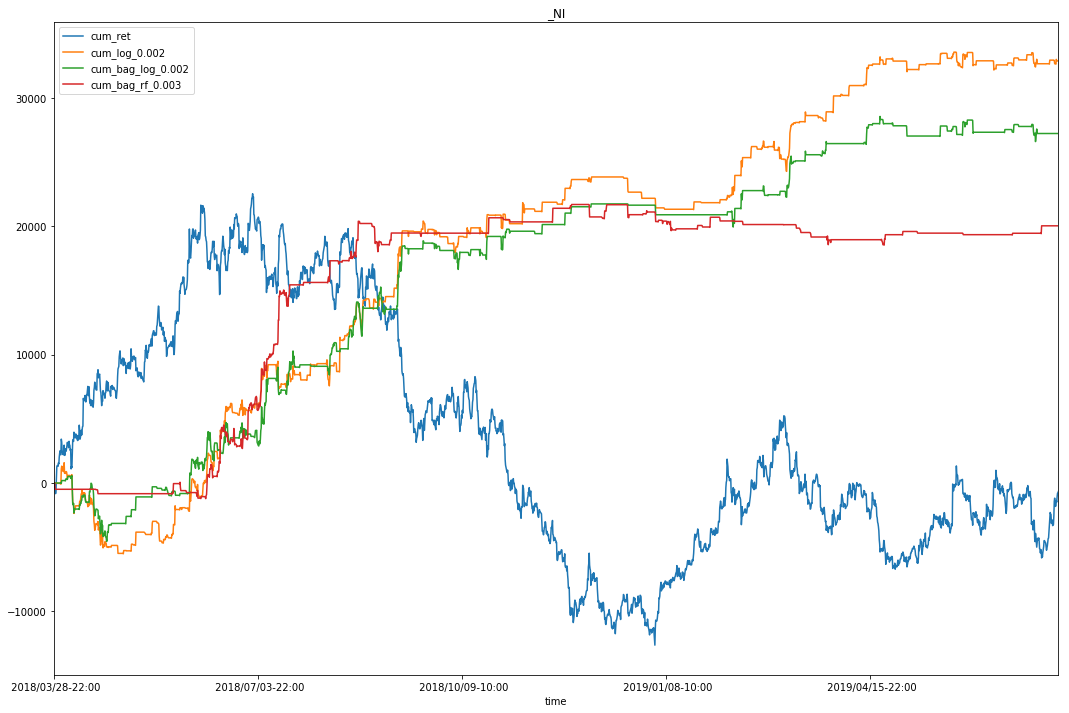

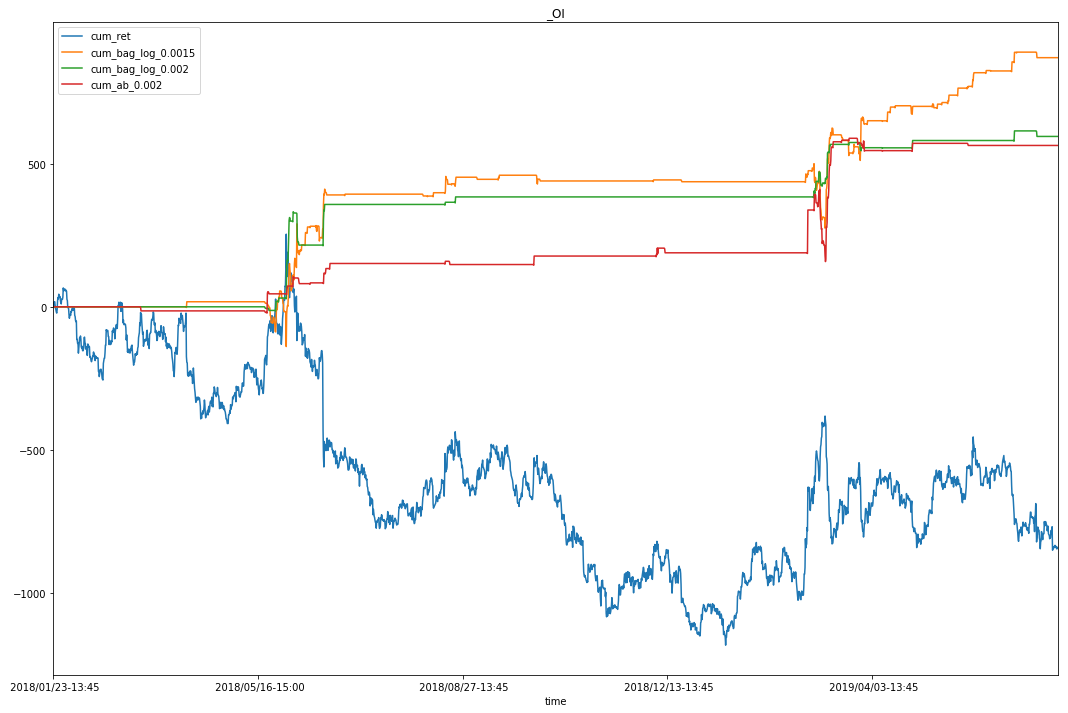

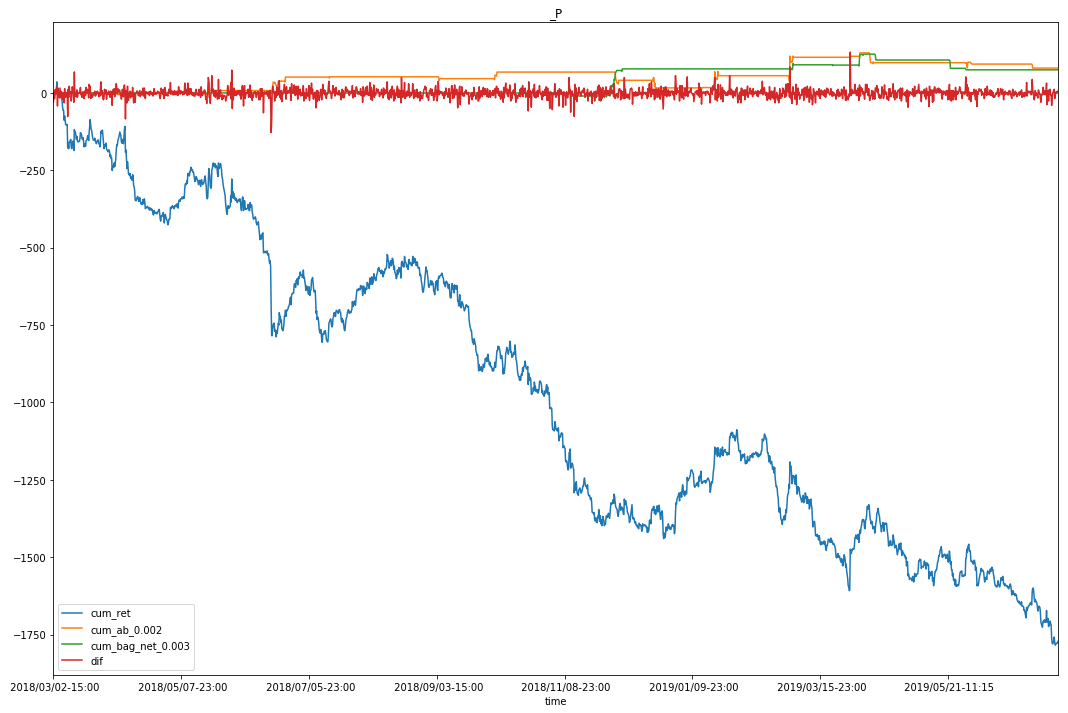

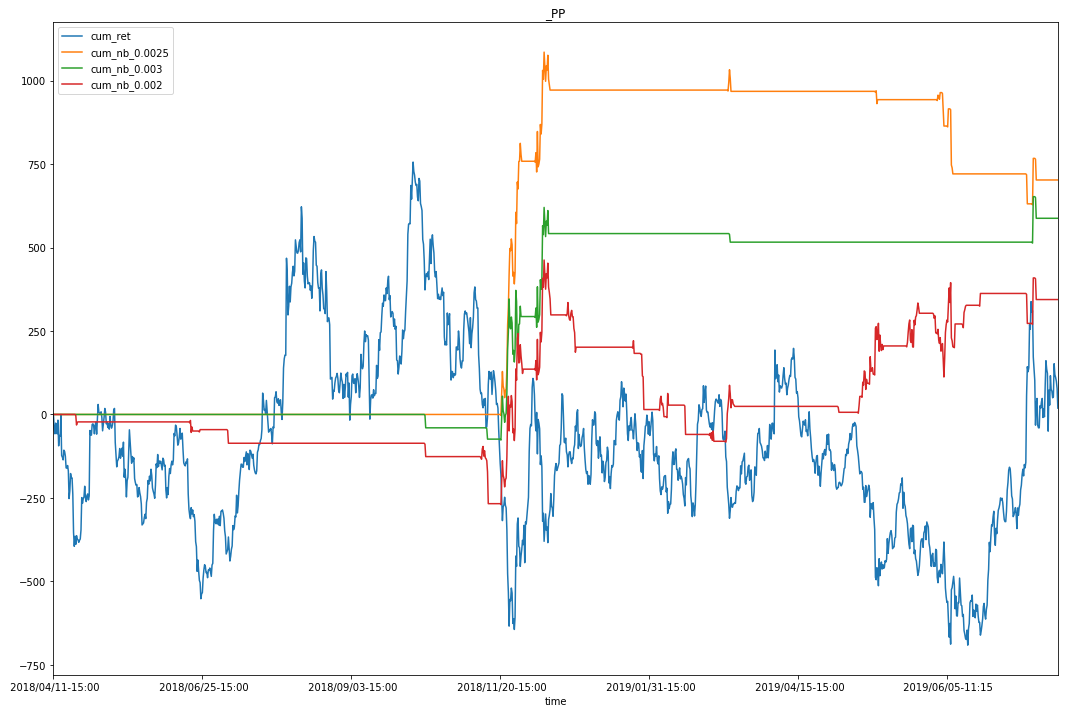

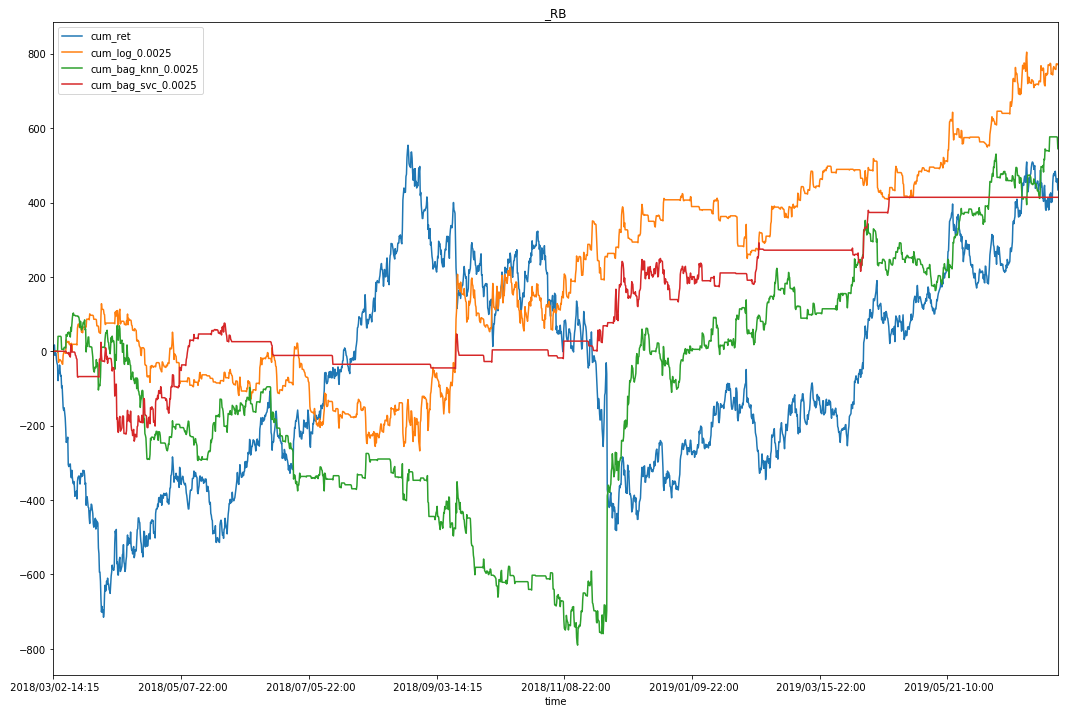

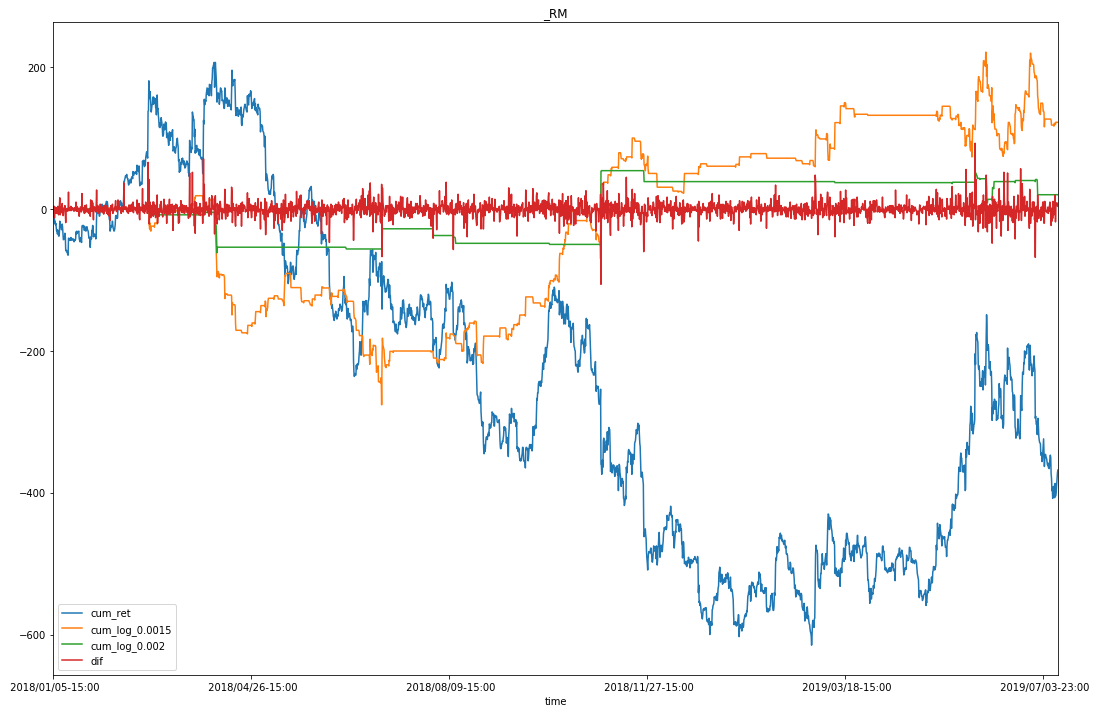

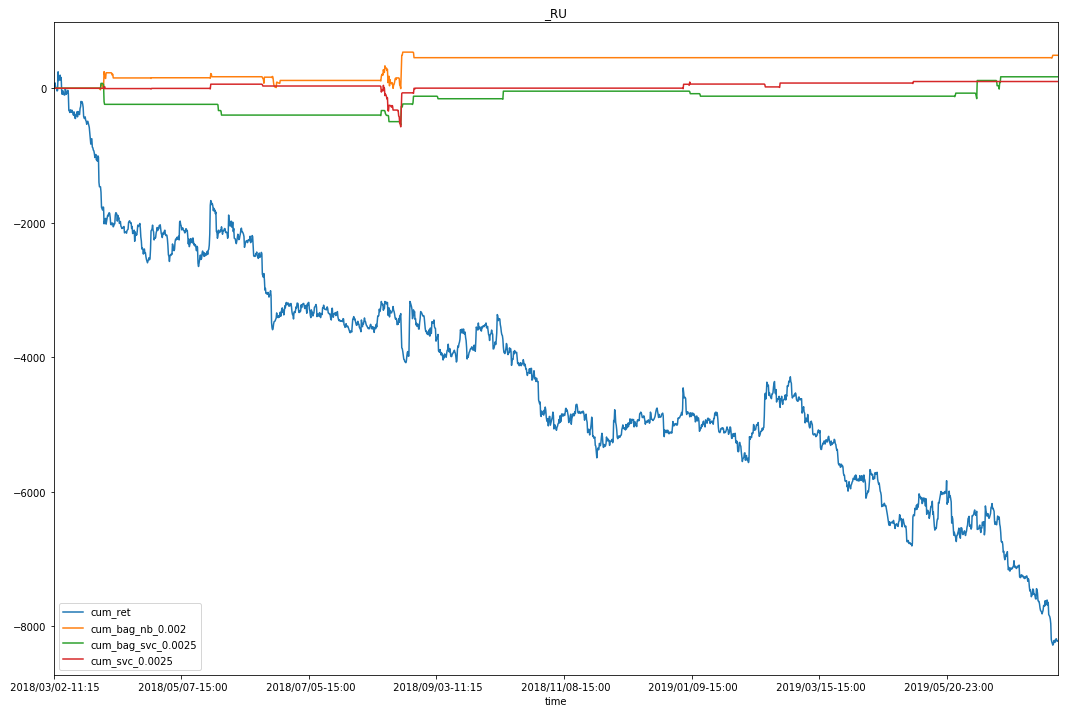

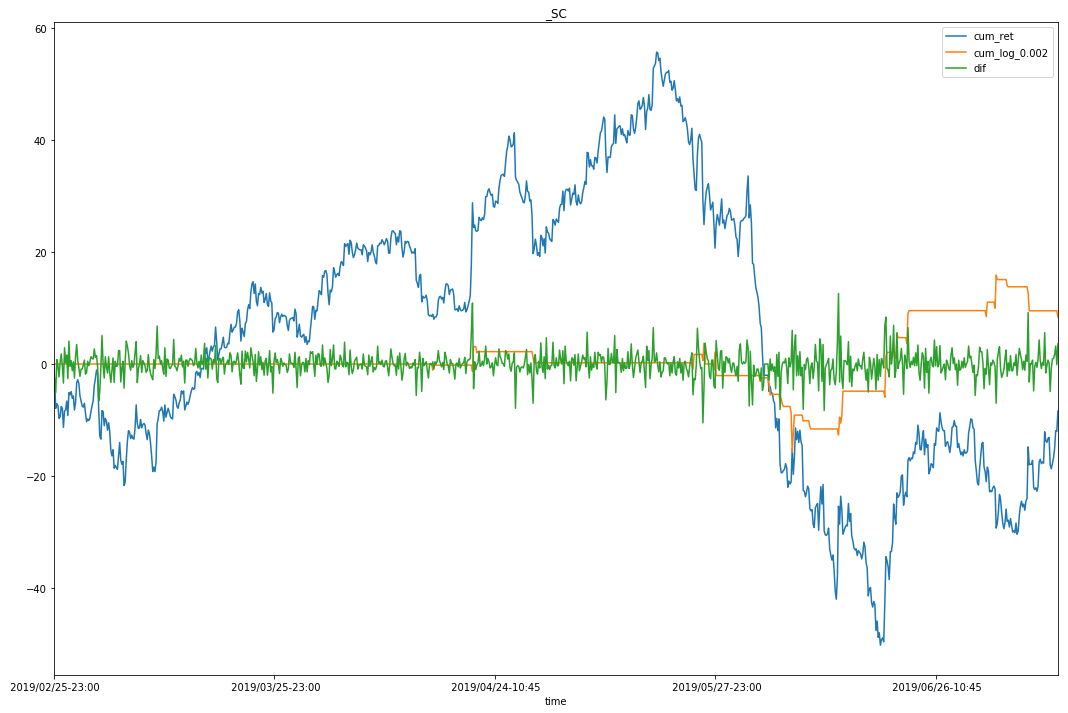

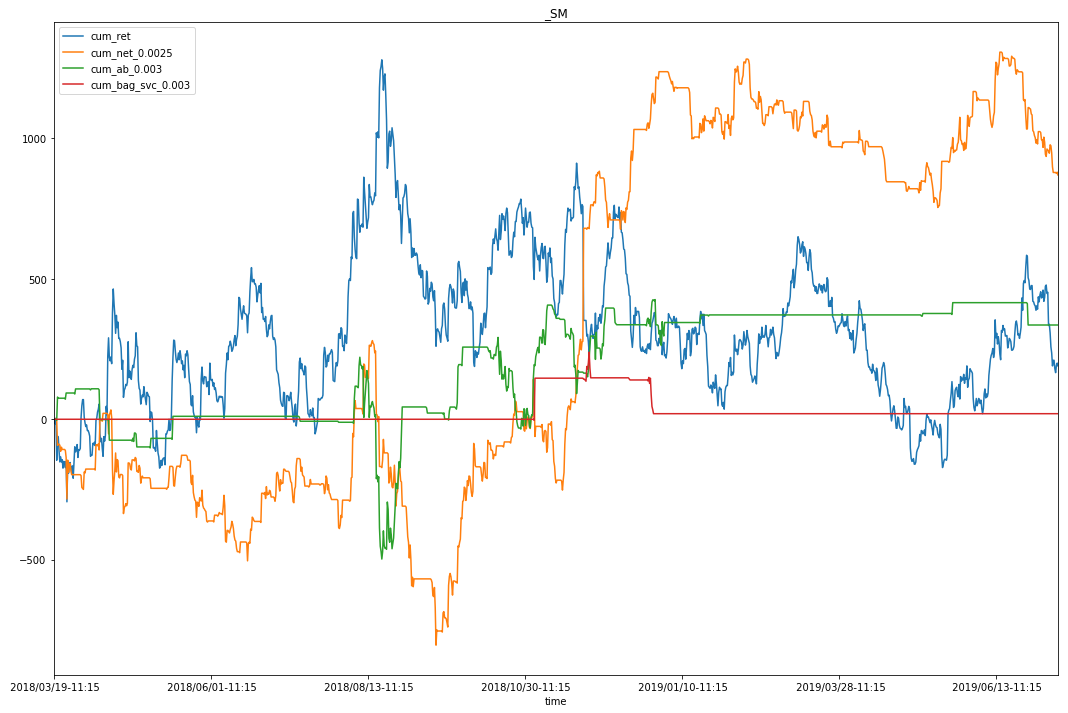

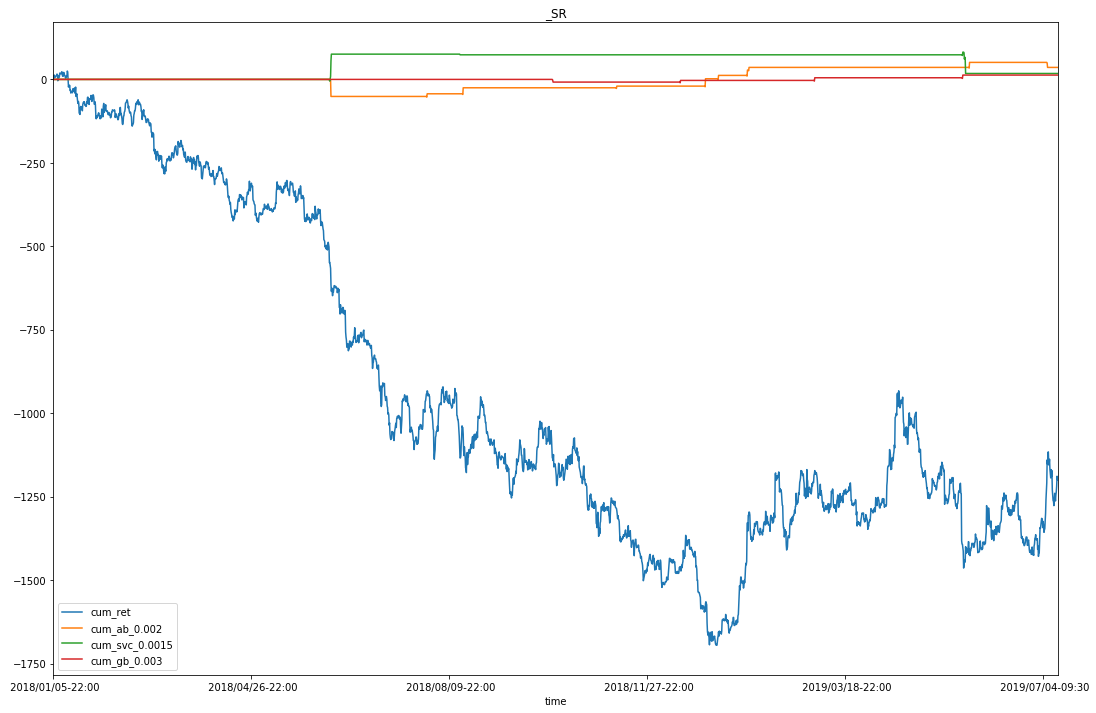

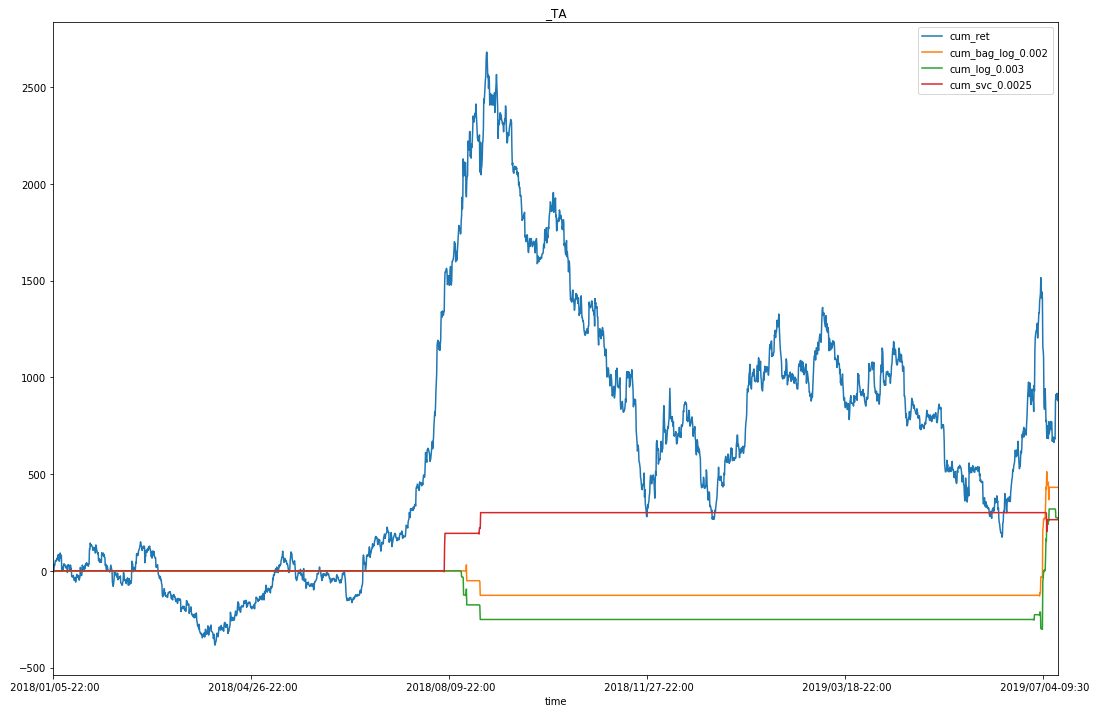

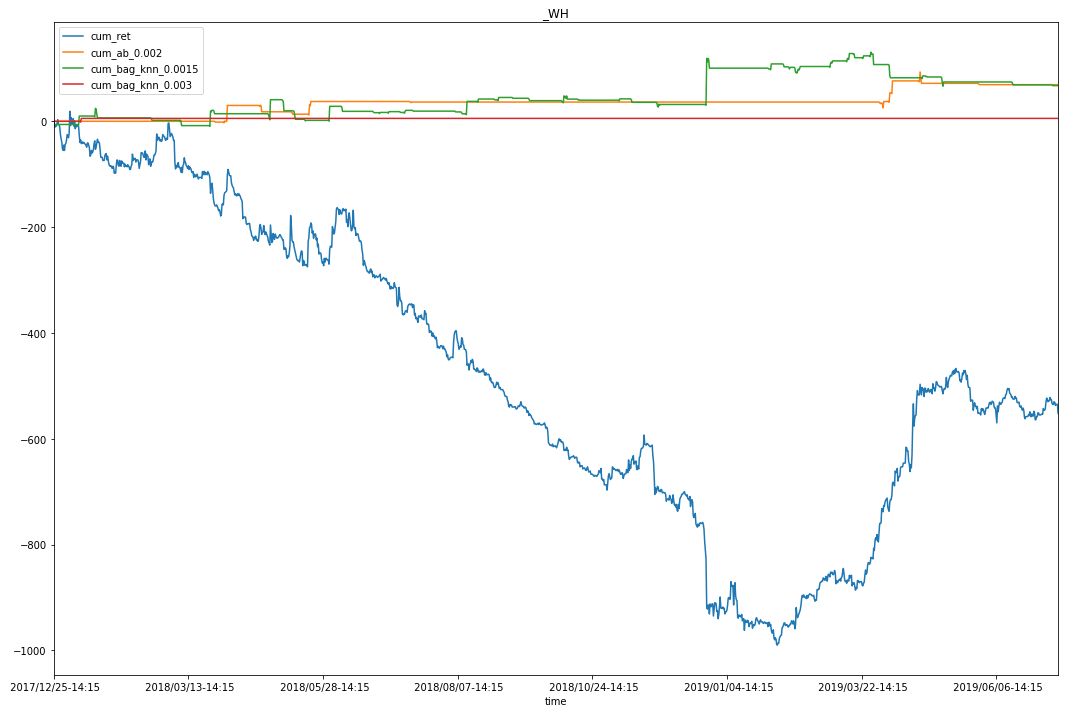

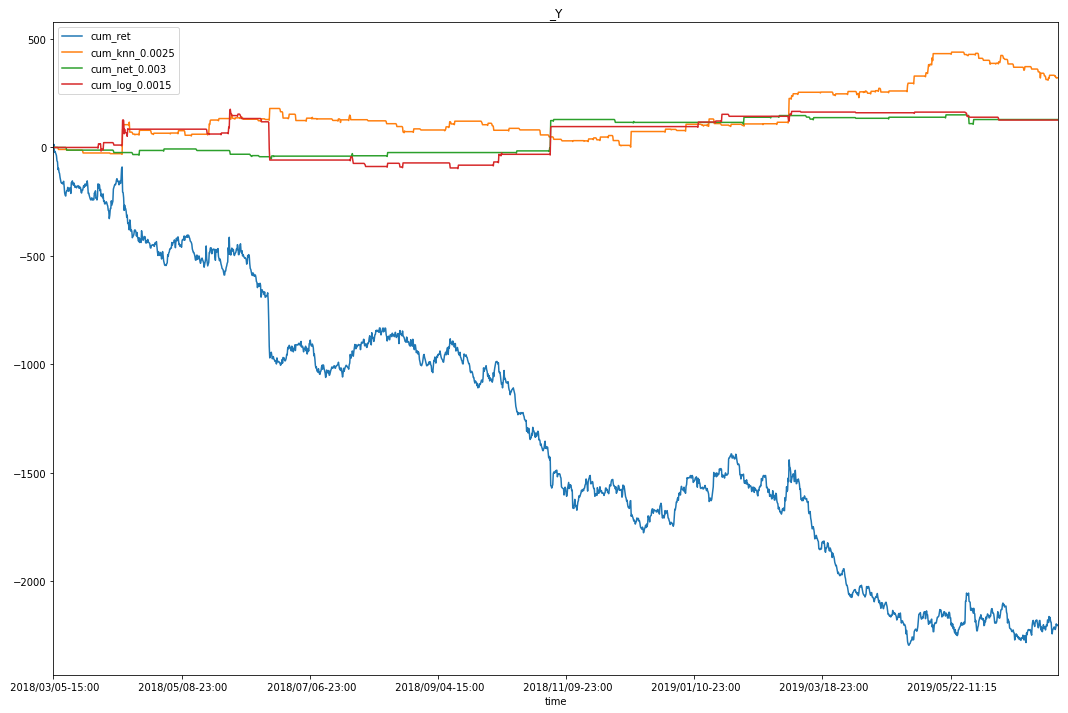

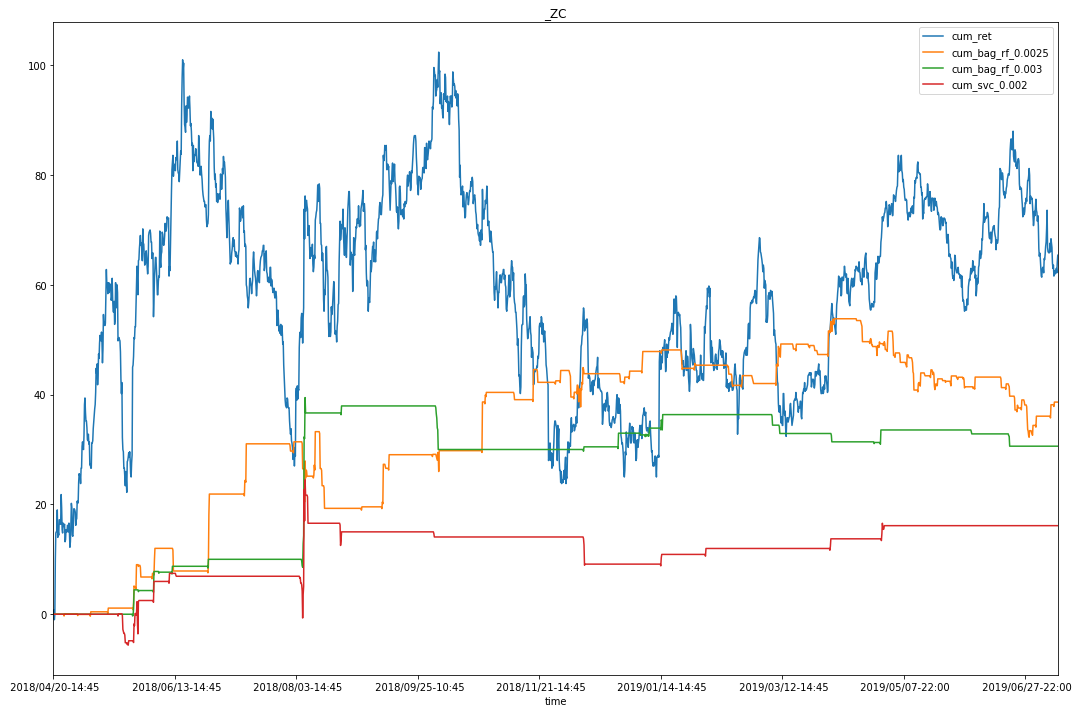

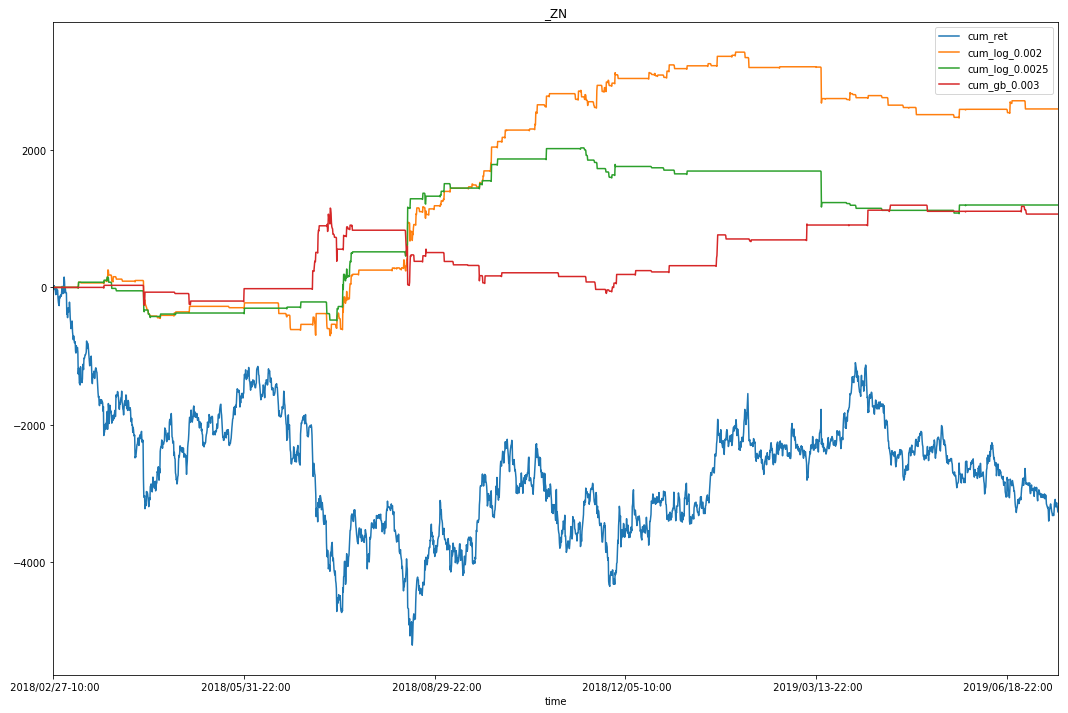

In [4]:
# ma.main_fit()
ma.fit()